# Effective Pandas
Starting from Chapter 25, and progressing until the notebook length becomes challenging.  Likely 100 cells of code across a the notebook.  Initiate notebook with data sets being leveraged in prior notebooks to facilitate continuation.

- Car data notebook with mpg data
- World cup history datasource
- Snow resort precipitation records
- Siena President evaluation data
- Jetbrains survey data

### Imports
Minimum imports to follow allong are pandas and numpy.  Potential to add matplotlib at a later point.  Unclear if this is needed at this time.

### Tweak Functions
Functions developed previously to optimize data will be leveraged to reset existing data to lower memory usage systems leveraging changins system used in Chapter 21.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import catboost as cb
import collections

Bad value in file WindowsPath('C:/Users/KNHOFFM/.matplotlib/stylelib/xom.mplstyle'), line 11 ('lines.color: #0C479D'): Key lines.color: '' does not look like a color arg
Bad value in file WindowsPath('C:/Users/KNHOFFM/.matplotlib/stylelib/xom.mplstyle'), line 15 ('patch.edgecolor: #FFFFFF'): Key patch.edgecolor: '' does not look like a color arg
Bad value in file WindowsPath('C:/Users/KNHOFFM/.matplotlib/stylelib/xom.mplstyle'), line 16 ('patch.facecolor: #0C479D'): Key patch.facecolor: '' does not look like a color arg


### Datasets

In [2]:
cars = pd.read_csv("vehicles.csv")

c:\users\knhoffm\.virtualenvs\python_for_engineer_science\lib\site-packages\IPython\core\interactiveshell.py:3378: DtypeWarning: Columns (70,71,72,73,74,76,79) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
fifa = pd.read_csv("international_matches.csv")

In [4]:
alta_df = pd.read_csv('alta-noaa-1980-2019.csv')

In [5]:
pres_df = pd.read_csv('siena2018-pres.csv', index_col=0)

In [6]:
jb = pd.read_csv('2020-jetbrains-python-survey.csv') # normally pursue url

c:\users\knhoffm\.virtualenvs\python_for_engineer_science\lib\site-packages\IPython\core\interactiveshell.py:3378: DtypeWarning: Columns (152) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Tweak Dataset optimization
Pulled from prior sessions to prep datasets in advance of further analysis and interogation.  This will be pulled where already developed and loaded into this notebook.
- World Cup data set
- Siena Presidents
- Jetbrains survey

### JetBrains Dataset tweak
---

In [7]:
def get_uniu_cols(jb): 
    # jb here is to help see the passed data, but not technically require as it confuses the name space
    '''This function is unique to this data set due to the field structure using periods and having duplicate fields.
    It strips out the variants of a column, and targets the root fields for the dataset'''
    counter = collections.defaultdict(list)
    for col in sorted(jb.columns):
        period_count = col.count('.')
        if period_count >= 2:
            part_end = 2
        else:
            part_end = 1
        parts = col.split('.')[:part_end]
        counter['.'.join(parts)].append(col)
    uniq_cols = []
    for cols in counter.values():
        if len(cols) == 1:
            uniq_cols.extend(cols)
    return uniq_cols

In [8]:
def prep_for_ml(df):
    # remove pandas specific dtypes
    '''Specifically done to help with the use of catboost, which requires base Python types'''
    return (df
            .assign(**{col:df[col].astype(float) for col in df.select_dtypes('number')},
                    **{col:df[col].astype(str).fillna('') for col in df.select_dtypes(['object', 'category'])})
           )

In [9]:
def predict_col(df, col):
    '''leverages the prep_for_ml return value to conduct prediction on the series and return a series with
    missing data imputed based on the prediction engine'''
    df = prep_for_ml(df)
    missing = df.query(f'~{col}.isna()')
    cat_idx = []
    for i, typ in enumerate(df.drop(columns=[col]).dtypes):
        if str(typ) == 'object':
            cat_idx.append(i)
    X = (missing.drop(columns=[col]).values)
    y = missing[col]
    model = cb.CatBoostRegressor(iterations=20, cat_features=cat_idx)
    model.fit(X, y, cat_features=cat_idx)
    pred = model.predict(df.drop(columns=[col]))
    return df[col].where(~df[col].isna(), pred)

In [10]:
def tweak_jb(jb):
    '''Full clean up and modification of jb dataframe from jetbrains survey response'''
    uniq_cols = get_uniu_cols(jb)
    return (jb
            [uniq_cols]
            .rename(columns=lambda c:c.replace('.','_'))
            .assign(age = lambda df_:df_.age.str[:2].astype(float).astype('Int64'),
                    are_you_datascientist = lambda df_: df_.are_you_datascientist
                        .replace({'Yes':True,'No':False,np.nan:False}),
                    company_size = lambda df_:df_.company_size.replace({'51–500':51,'More than 5,000':5000,
                        '11–50':11,'2–10':2,'1,001–5,000':1001,'Just me':1,'501–1,000':501,'Not sure':np.nan})
                        .astype('Int64'),
                    country_live = lambda df_:df_.country_live.astype('category'),
                    employment_status = lambda df_:df_.employment_status.fillna('Other').astype('category'),
                    is_python_main = lambda df_:df_.is_python_main.astype('category'),
                    team_size = lambda df_: df_.team_size.str.split(r'-', n=1, expand=True)
                        .iloc[:,0].replace('More than 40 people',41)
                        .where(df_.company_size!=1, 1).astype(float),
                    years_of_coding = lambda df_: df_.years_of_coding.replace('Less than 1 year',0.5)
                        .str.extract(r'(\d+)').astype(float),
                    python3_ver = lambda df_:df_.python3_version_most.str.replace('_','.')
                        .str.extract(r'(\d\.\d)').astype(float),
                    use_python_most = lambda df_: df_.use_python_most.fillna('Unknown')
                   )
            .assign(team_size = lambda df_: predict_col(df_, 'team_size').astype(int))
            .drop(columns=['python2_version_most'])
            .dropna()
           )

In [11]:
jb = tweak_jb(jb)

Learning rate set to 0.5
0:	learn: 2.9835208	total: 214ms	remaining: 4.07s
1:	learn: 2.8774954	total: 276ms	remaining: 2.48s
2:	learn: 2.8394639	total: 330ms	remaining: 1.87s
3:	learn: 2.8050221	total: 386ms	remaining: 1.54s
4:	learn: 2.7869339	total: 438ms	remaining: 1.31s
5:	learn: 2.7743464	total: 493ms	remaining: 1.15s
6:	learn: 2.7620047	total: 548ms	remaining: 1.02s
7:	learn: 2.7579574	total: 603ms	remaining: 905ms
8:	learn: 2.7499983	total: 656ms	remaining: 801ms
9:	learn: 2.7459189	total: 718ms	remaining: 718ms
10:	learn: 2.7455531	total: 770ms	remaining: 630ms
11:	learn: 2.7417426	total: 821ms	remaining: 547ms
12:	learn: 2.7409715	total: 871ms	remaining: 469ms
13:	learn: 2.7397709	total: 926ms	remaining: 397ms
14:	learn: 2.7329598	total: 980ms	remaining: 327ms
15:	learn: 2.7271657	total: 1.03s	remaining: 258ms
16:	learn: 2.7223690	total: 1.08s	remaining: 191ms
17:	learn: 2.7209157	total: 1.14s	remaining: 127ms
18:	learn: 2.7162403	total: 1.19s	remaining: 62.7ms
19:	learn: 2.71

### Siena Dataset tweak
---

In [12]:
def tweak_siena(df):
    """Convert Siena presidential Dataframe into a more usable format with appropriate dtypes"""
    def int64_to_uint8(df_):
        """convert int columns to uint8 dtype for space/memory"""
        cols = df_.select_dtypes('int64')
        return (df_
                .astype({col:'uint8' for col in cols})
               )
    return (df
            .rename(columns={'Seq.':'Seq'}) #1 column name update
            .rename(columns={k:v.replace(' ','_') for k,v in
                {'Bg':'Background',
                 'PL':'Party Leadership','CAb':'Communication ability',
                 'RC':'Relations with Congress','CAp':'Court appointments',
                 'HE':'Handling of economy','L':'Luck',
                 'AC':'Ability to compromise','WR':'Willing to take risks',
                 'EAp':'Executive appointments','OA':'Overall Ability',
                 'Im':'Imagination','DA':'Domestic accomplishments',
                 'Int':'Integrity','EAb':'Executive ability',
                 'FPA':'Foriegn policy accomplishments',
                 'LA':'Leadership ability',
                 'IQ':'Intelligence','AM':'Avoid crucial mistakes',
                 'EV':'Experts view','O':'Overall'}.items()})
            .astype({'Party':'category'}) #2 category convert
            .pipe(int64_to_uint8) #3 dtypes
            .assign(Average_rank=lambda df_:(df_.select_dtypes('uint8') #4 create new columns
                            .sum(axis=1).rank(method='dense').astype('uint8')),
                   Quartile=lambda df_:pd.qcut(df_.Average_rank, 4,
                        labels='Ist 2nd 3rd 4th'.split())
                   )
           )

In [13]:
pres = tweak_siena(pres_df)

### Fifa Dataset Tweak
---

In [14]:
def tweak_fifa(fifa):
    return (fifa
            .assign(date = lambda df_:pd.to_datetime(df_.date),
                    home_team = lambda df_:df_.home_team.astype('category'),
                    away_team = lambda df_:df_.away_team.astype('category'),
                    home_team_continent = lambda df_:df_.home_team_continent.astype('category'),
                    away_team_continent = lambda df_:df_.away_team_continent.astype('category'),
                    home_team_fifa_rank = lambda df_:df_.home_team_fifa_rank.astype('int32'),
                    away_team_fifa_rank = lambda df_:df_.away_team_fifa_rank.astype('int32'),
                    home_team_total_fifa_points = lambda df_:df_.home_team_total_fifa_points.astype('int32'),
                    away_team_total_fifa_points = lambda df_:df_.away_team_total_fifa_points.astype('int32'),
                    home_team_score = lambda df_:df_.home_team_score.astype('int8'),
                    away_team_score = lambda df_:df_.away_team_score.astype('int8'),
                    tournament = lambda df_:df_.tournament.astype('category'),
                    city = lambda df_:df_.city.astype('category'),
                    country = lambda df_:df_.country.astype('category'),
                    shoot_out = lambda df_: df_.shoot_out.where(df_.shoot_out=='Yes',True).where(df_.shoot_out=='No',False),
                    home_team_result = lambda df_:df_.home_team_result.astype('category'))
           )

In [15]:
fifa = tweak_fifa(fifa)

## Chapter 25 - Plotting with Dataframes
Plotting is an essential part of the data wrangling and data interogation process.  Without it, aspects of the data will be missed looking at pure numbers.  This is where the integration with matplotlib is really effective in 

### Line plots
The most essential and possibly the most immediately at hand, line plots provide immediate contact about data and the behavior of the subject across time (or whatever the records are based on).  

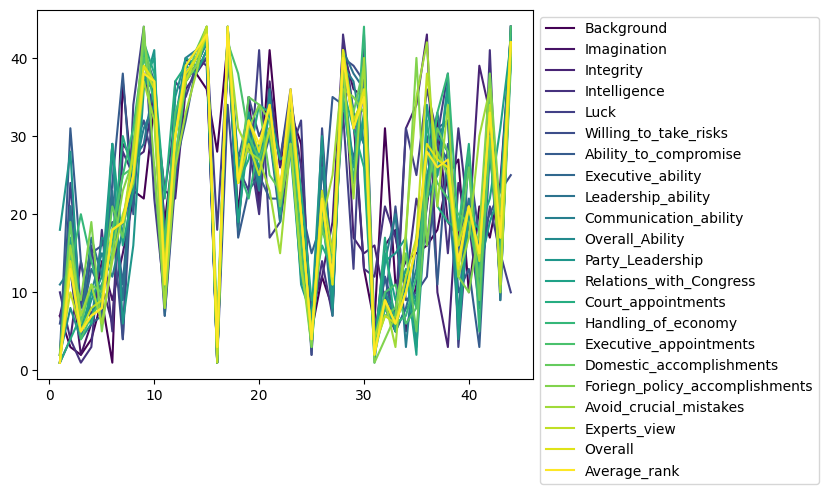

In [16]:
(pres
 .plot(cmap='viridis').legend(bbox_to_anchor=(1,1))
)

<AxesSubplot: xlabel='year'>

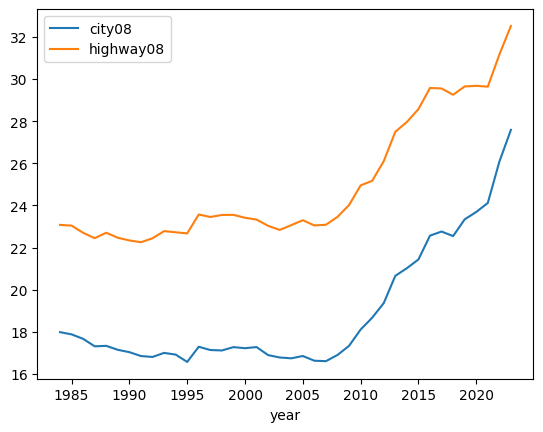

In [17]:
(cars
 [['make','year','city08','highway08']]
 .groupby('year')
 .mean()
 .plot()
)

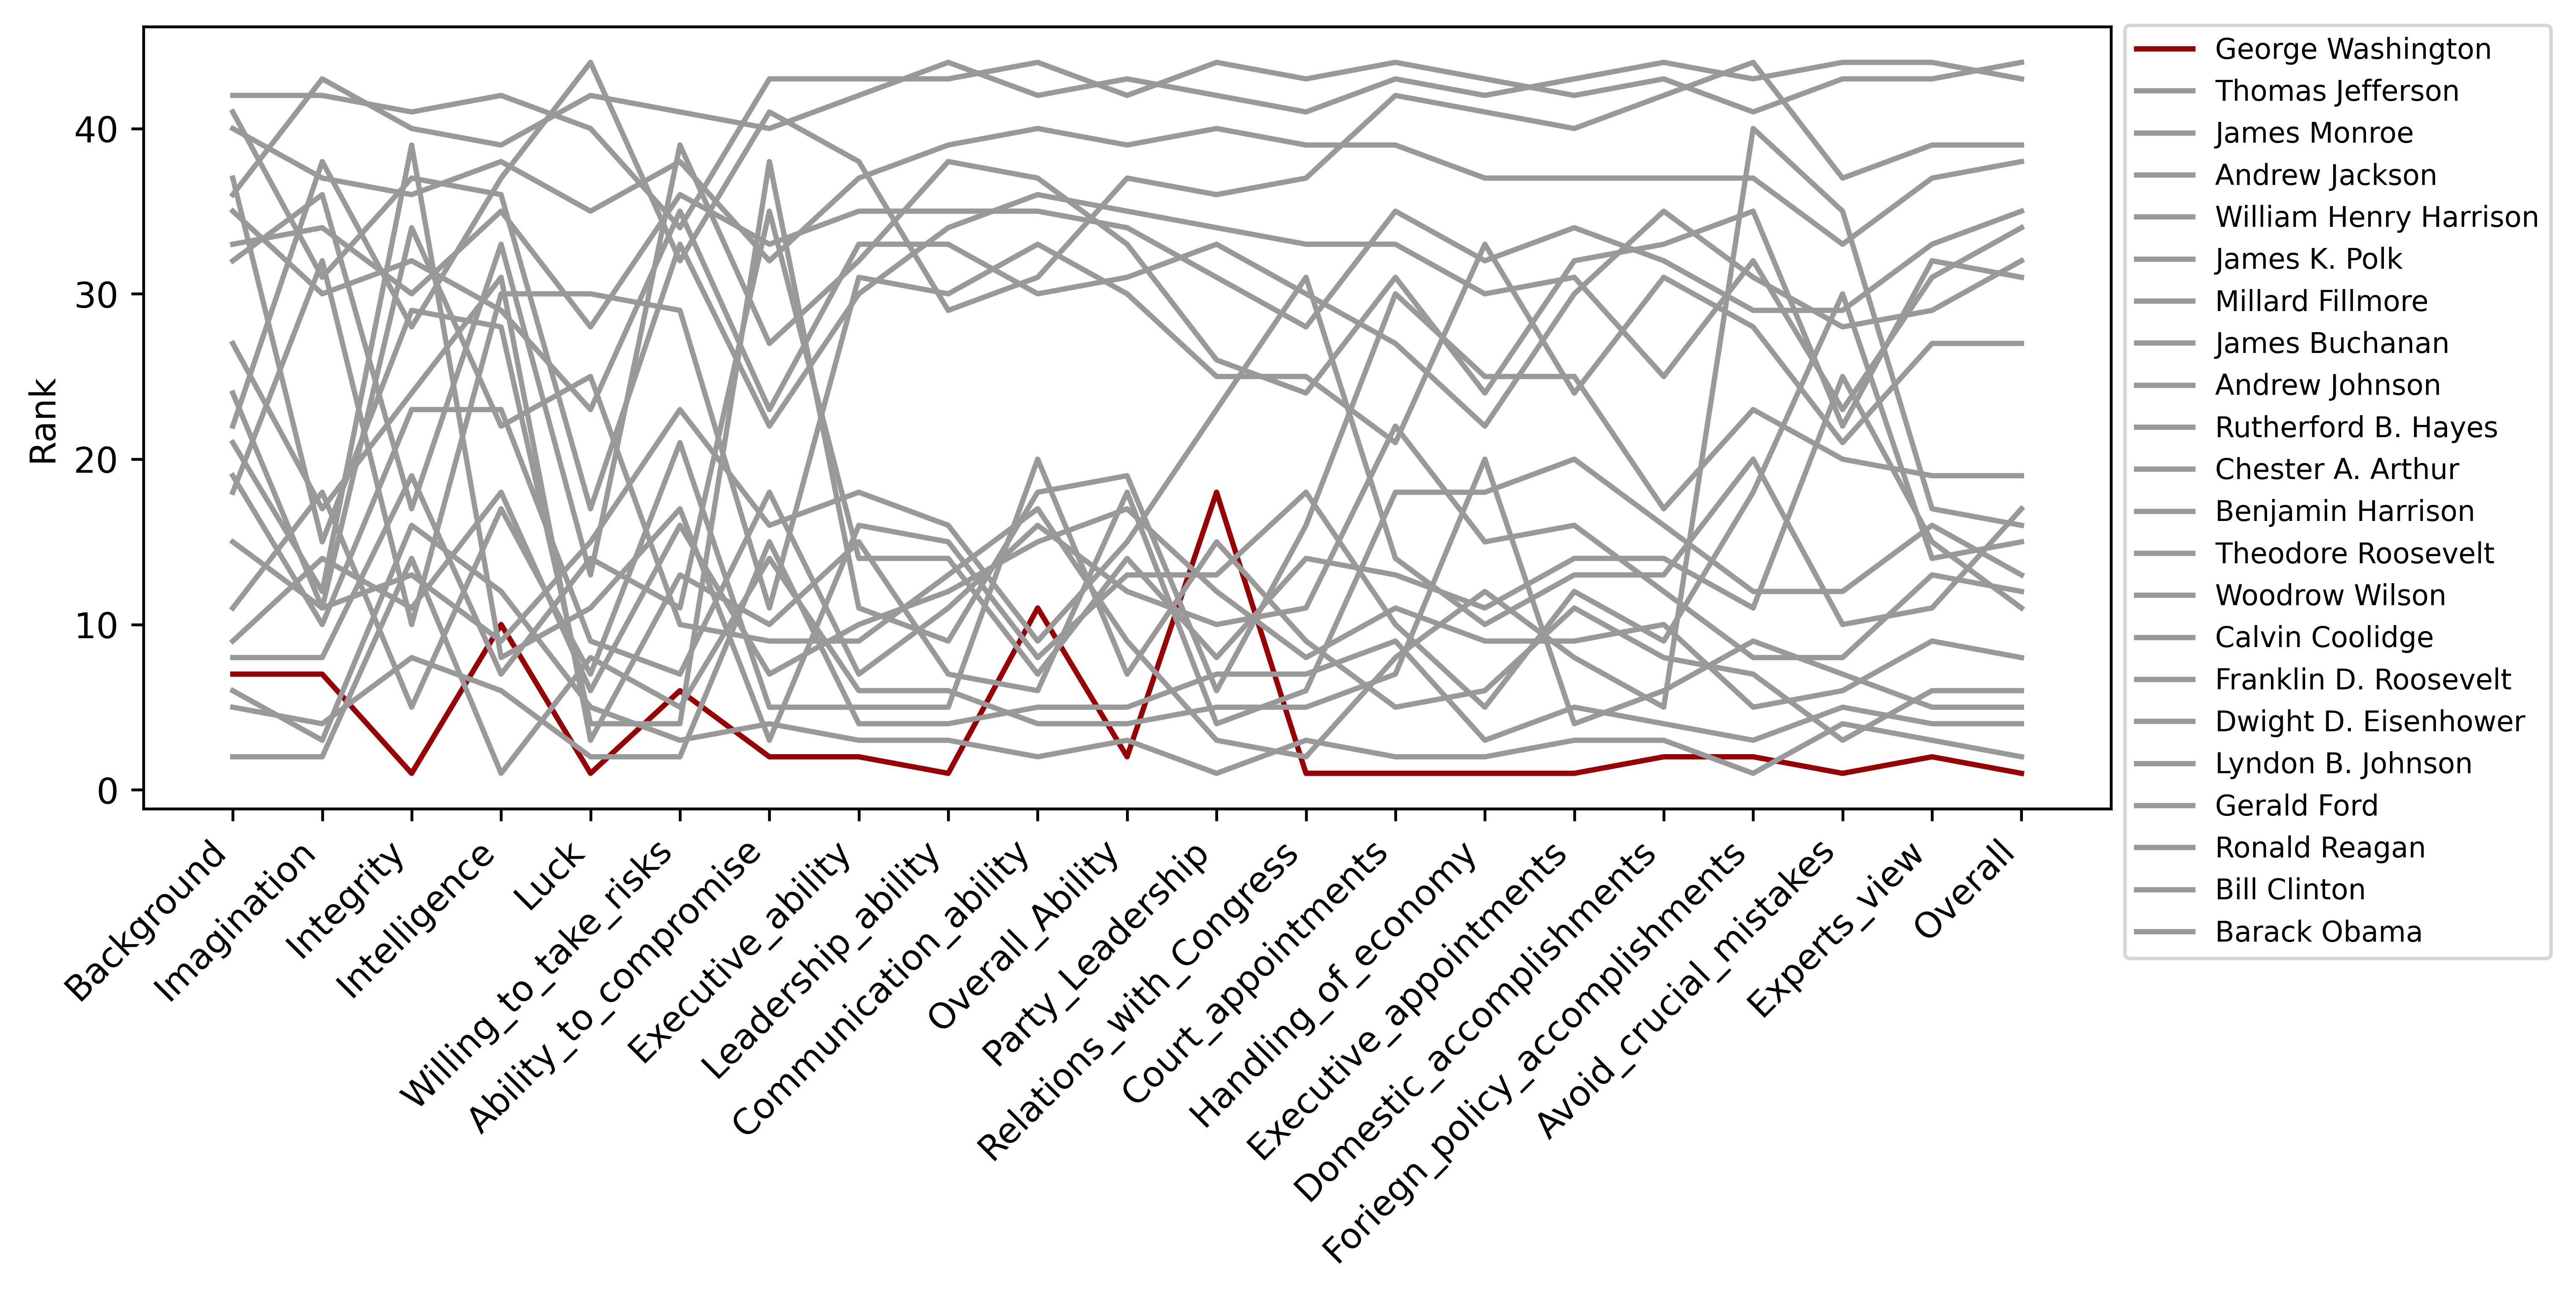

In [18]:
fig,ax = plt.subplots(dpi=600, figsize=(10,4))
colors = []
def set_colors(df):
    for col in df.columns:
        if 'George' in col:
            colors.append('#990000')
        else:
            colors.append('#999999')
    return df
            
(pres
 .set_index('President')
 .loc[::2,'Background':'Overall']
 .T
 .pipe(set_colors)
 .plot(ax=ax, rot=45, color=colors)
 .legend(bbox_to_anchor=(1,1.02), fontsize=8)
)

ax.set_xticks(range(21))
ax.set_xticklabels(pres.loc[:,'Background':'Overall'].columns, ha='right')
ax.set_ylabel('Rank');

### Bar Plots
Always a great way to visualize categorical data...

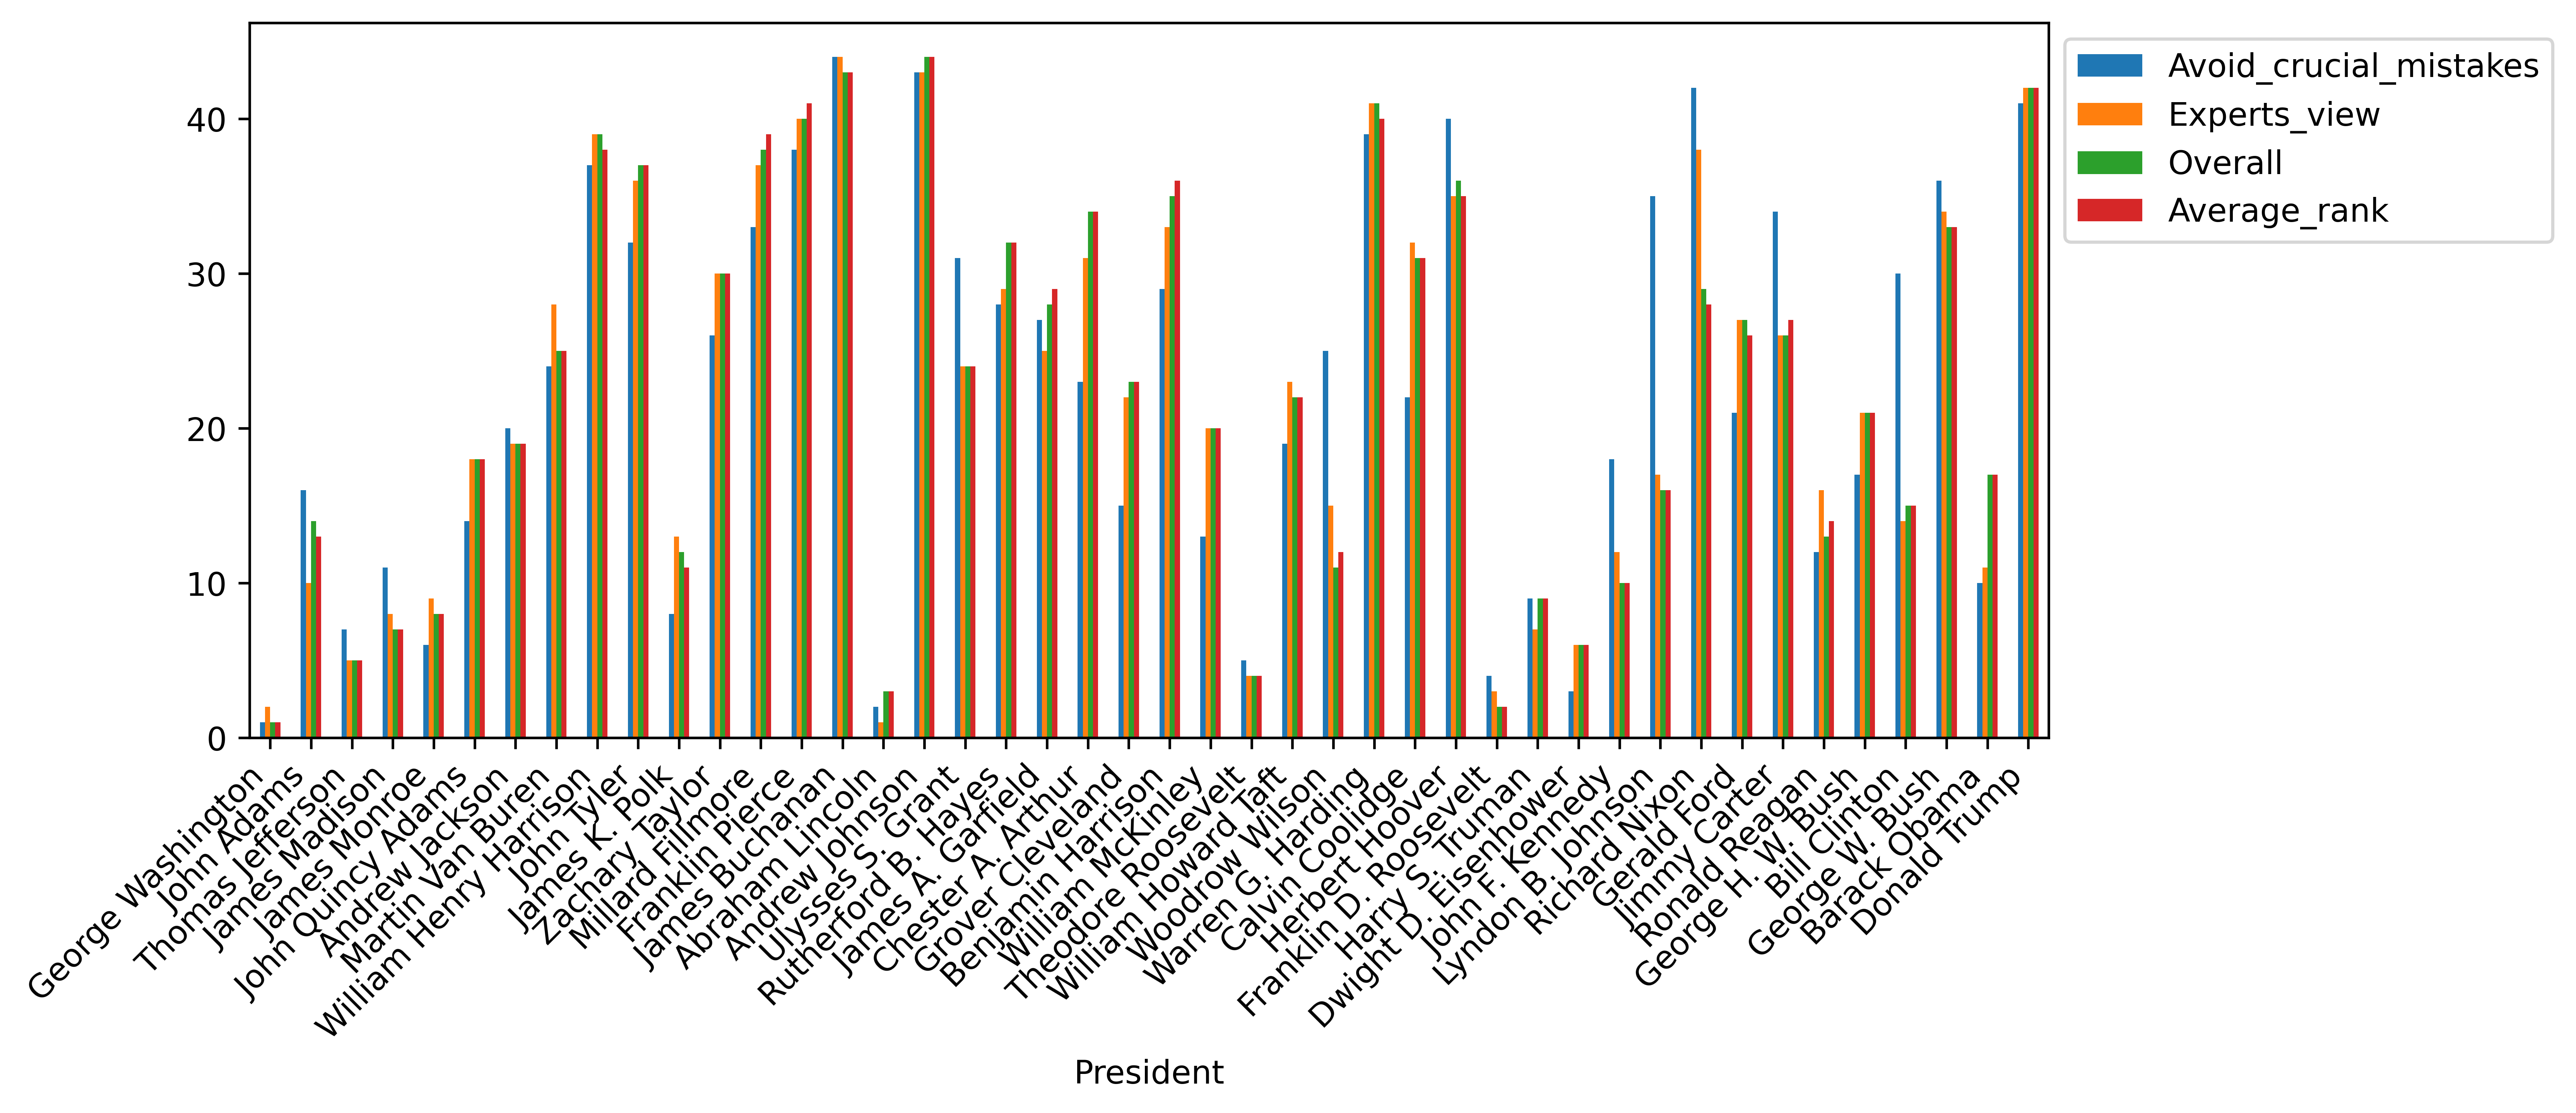

In [19]:
fig,ax = plt.subplots(dpi=600, figsize=(10,4))
(pres
 .set_index('President')
 .iloc[:,-5:-1]
 .plot.bar(rot=45, ax=ax)
)

ax.set_xticklabels(labels=ax.get_xticklabels(), ha='right')
ax.legend(bbox_to_anchor=(1,1))

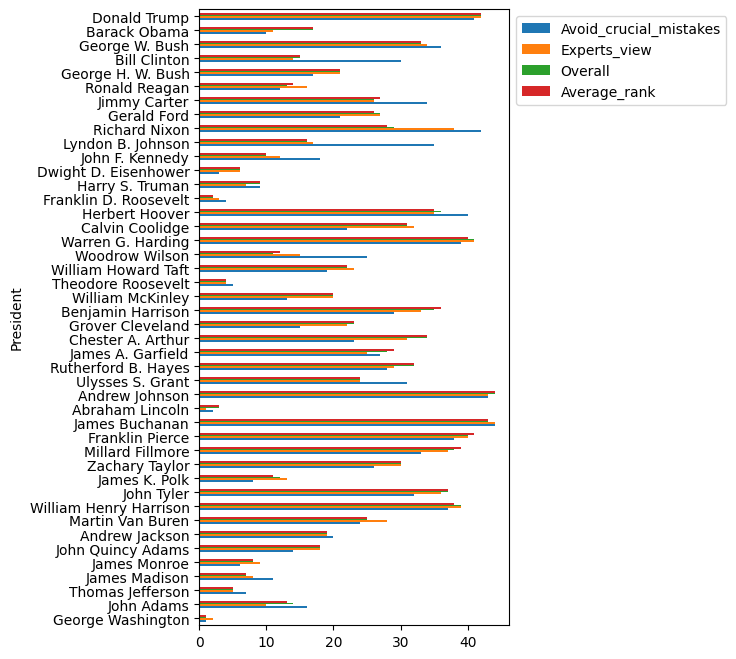

In [20]:
(pres
 .set_index('President')
 .iloc[:,-5:-1]
 .plot.barh(figsize=(4,8))
 .legend(bbox_to_anchor=(1,1))
);

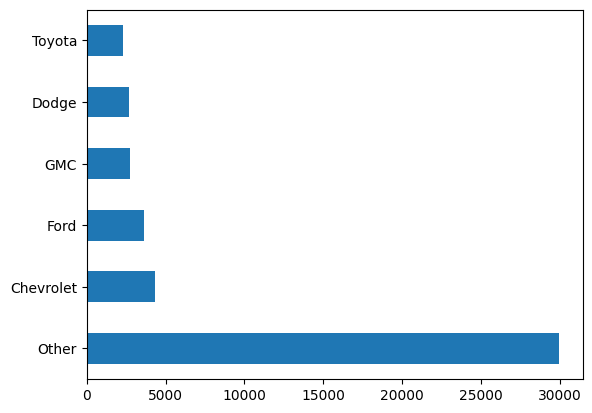

In [21]:
def topn(ser, n=5):
    vals = ser.value_counts().index[:n]
    return ser.where(ser.isin(vals), 'Other')

(cars
 [['make','year','city08','highway08']]
 .make
 .pipe(topn)
 .value_counts()
 .plot.barh()
);

### Scatter Plots
The best way to understand the relationship between two different columsn which are numeric is to place them together on a scatter plot.  Generally, we are looking at how they move together, or what the relationship is between the two columns of data.

c:\users\knhoffm\.virtualenvs\python_for_engineer_science\lib\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='Integrity', ylabel='Avoid_crucial_mistakes'>

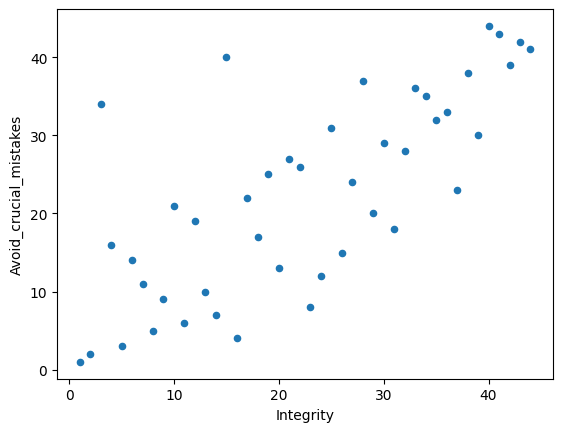

In [22]:
(pres
 .plot.scatter(x='Integrity', y='Avoid_crucial_mistakes')
)

#### Side track on Corr
See the correlation between any two numeric variables.  The Pearson correlation indicates how two variables move together.

In [23]:
pres.Integrity.corr(pres.Avoid_crucial_mistakes)

0.7455954897815362

In [24]:
import seaborn as sns

<AxesSubplot: >

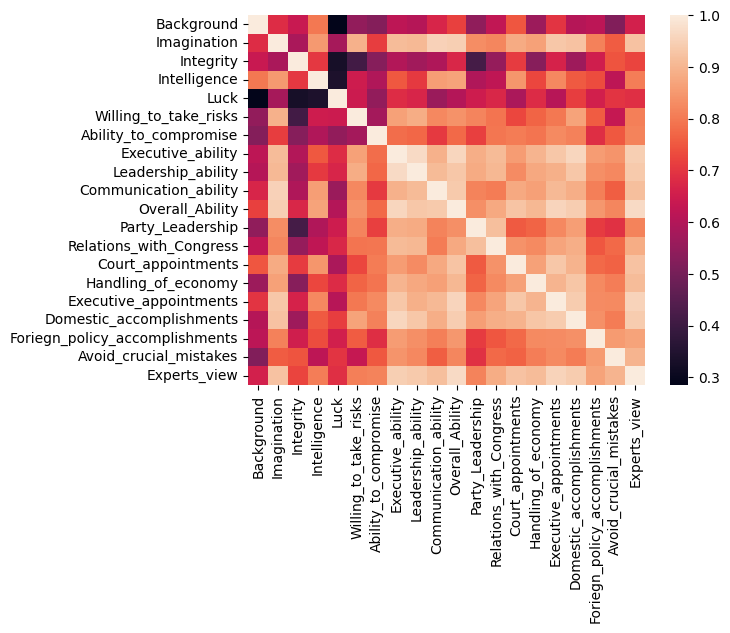

In [25]:
sns.heatmap(pres.iloc[:,:-3].corr())

### Scatterplots continued
There is the option to encode a number of levels of data.  
- x axis
- y axis
- point color
- point size

<AxesSubplot: xlabel='Integrity', ylabel='Avoid_crucial_mistakes'>

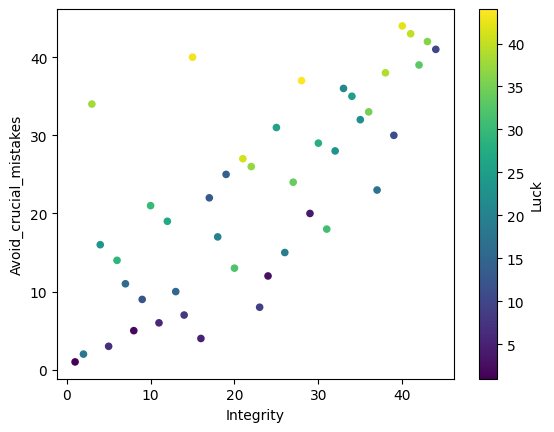

In [26]:
(pres
 .plot.scatter(x='Integrity', y='Avoid_crucial_mistakes', c='Luck', cmap='viridis')
)

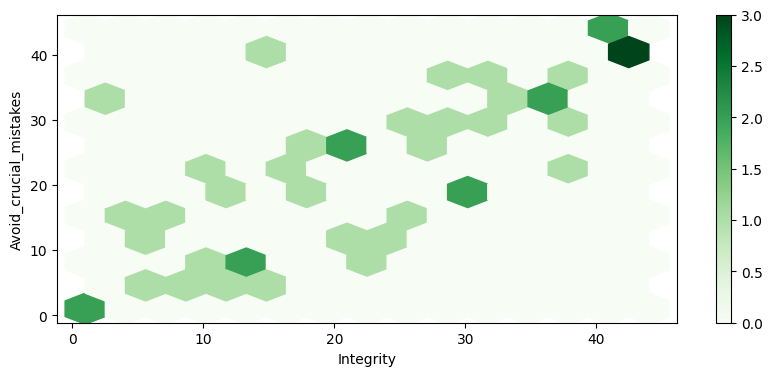

In [27]:
(pres
 .plot.hexbin(x='Integrity', y='Avoid_crucial_mistakes', cmap='Greens', figsize=(10,4), gridsize=(14,6) )
);# grid size has to be adjusted to group the values to see hex shapes correctly

### Area Plots and Stacked Bar Plots
Helpful to see relative contribution to a larger whole.  Approach stacking data carefully as it is difficult to differentiate the information in the bar from one entry to the next since there is not a common baseline.  

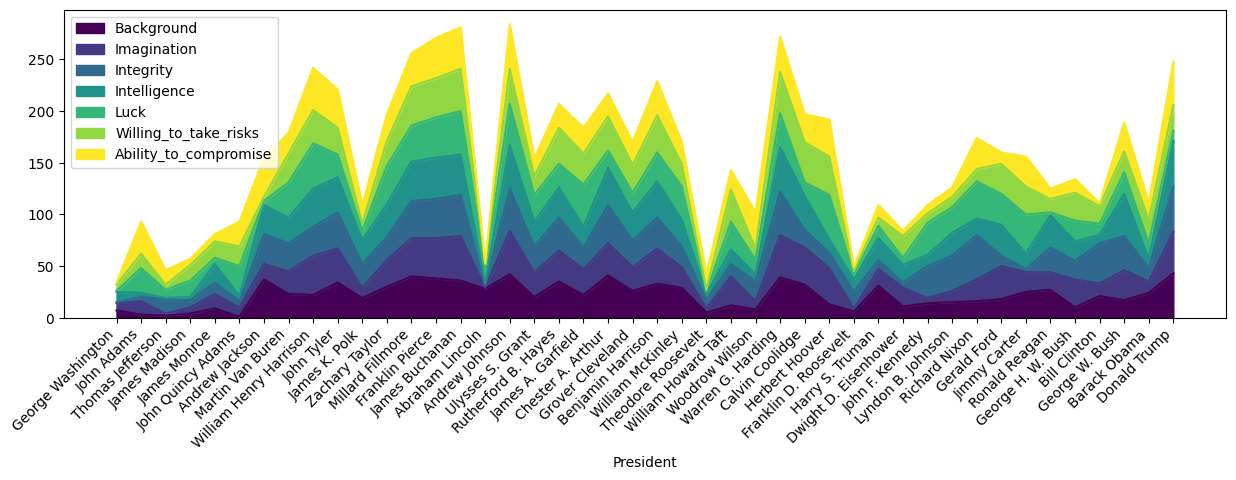

In [28]:
# area charts show relative contribution in specified order, but there should be an order
fig, ax = plt.subplots(figsize=(15,4))

(pres
 .plot.area(x='President', y=pres.select_dtypes('number').columns[:7], rot=45, ax=ax, cmap='viridis')
#  .legend(bbox_to_anchor=(0.75,1))
)

ax.set_xticks(range(len(pres)))
ax.set_xticklabels(labels=pres.President, ha='right', fontsize=10);

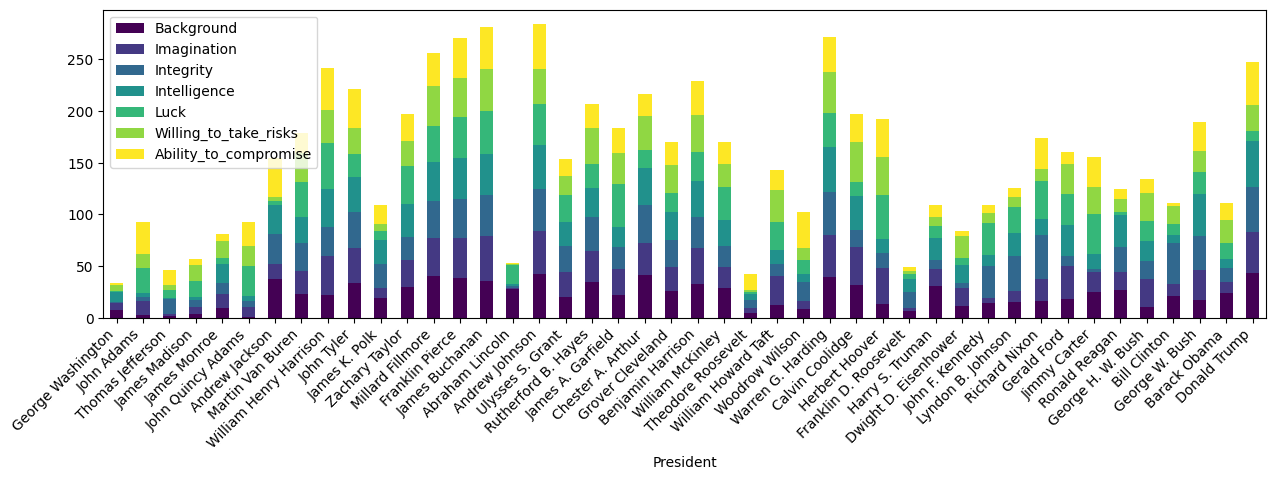

In [29]:
# area charts show relative contribution in specified order, but there should be an order
fig, ax = plt.subplots(figsize=(15,4))

(pres
 .plot.bar(x='President', y=pres.select_dtypes('number').columns[:7], rot=45, ax=ax, cmap='viridis', stacked=True)
#  .legend(bbox_to_anchor=(0.75,1))
)

ax.set_xticks(range(len(pres)))
ax.set_xticklabels(labels=pres.President, ha='right', fontsize=10);

### Column Distributions with KDEs, Historgrams and Boxplots
This is where things move toward a more statistical bent, and it one of the main advantages of code based disection of data.  It allows very quick manipulation of a dataset to see things from a different perspective.  Often, this new view can be very illuminating as to the scope and nature of your data. 

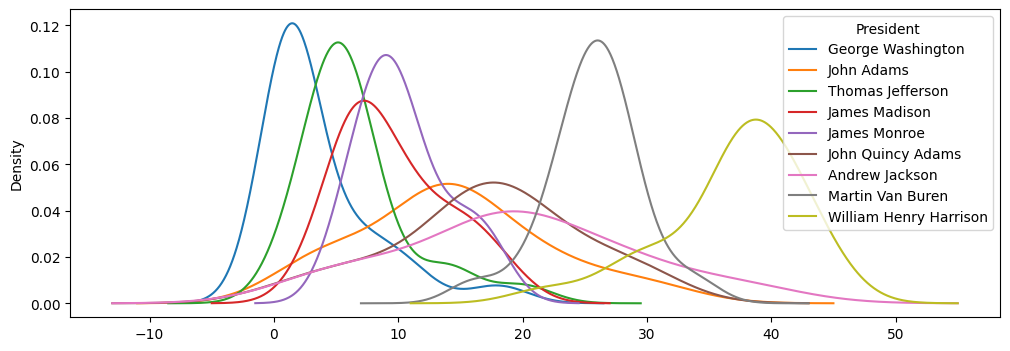

In [30]:
# KDE plot shows the central tendancy of the President's scores across all categories
(pres
 .set_index('President')
 .loc[:,'Background':'Average_rank']
 .iloc[:9]
 .T
 .plot.density(figsize=(12,4))
);

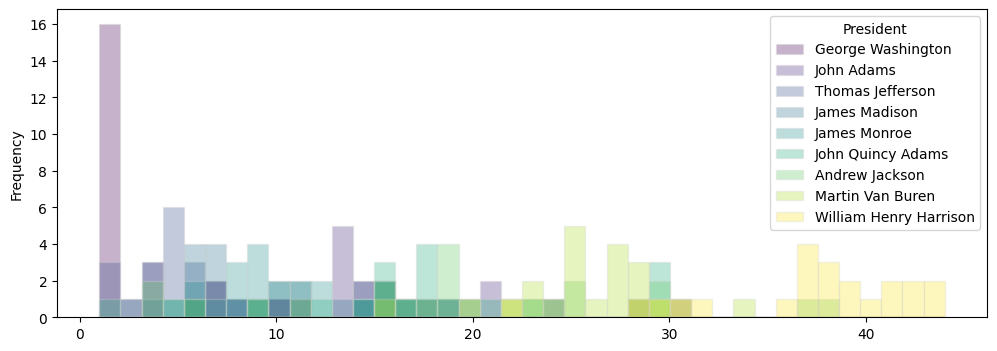

In [31]:
# KDE plot shows the central tendancy of the President's scores across all categories
(pres
 .set_index('President')
 .loc[:,'Background':'Average_rank']
 .iloc[:9]
 .T
 .plot.hist(bins=40, figsize=(12,4), edgecolor='lightgray', cmap='viridis', alpha=0.3)
);

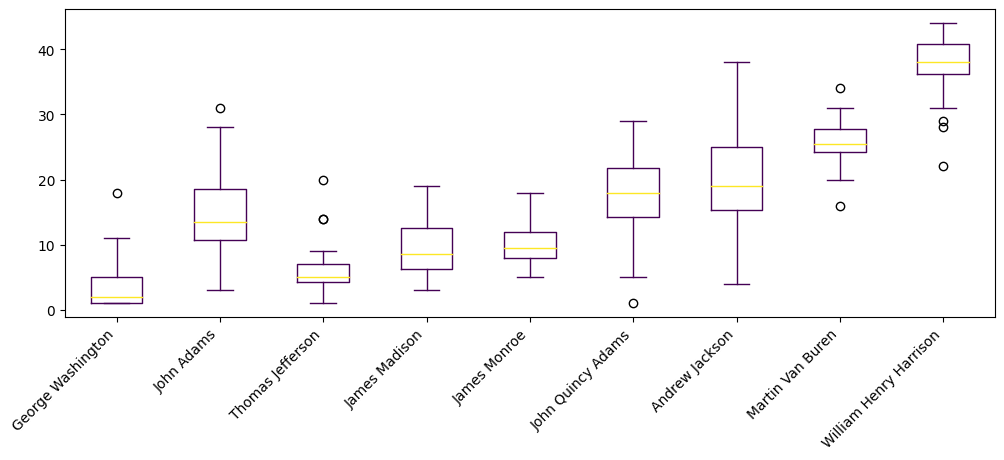

In [32]:
# KDE plot shows the central tendancy of the President's scores across all categories
ax = (pres
 .set_index('President')
 .loc[:,'Background':'Average_rank']
 .iloc[:9]
 .T
 .plot.box(figsize=(12,4), cmap='viridis', rot=45)
)

ax.set_xticklabels(labels=(pres.President[:9]), ha='right');

### Psets
With a dataset of your choice:
1. Create a historgram from a numeric column and change the bin size
2. Create a boxplot from a numeric column
3. Create a Kernal Density Estimate from a numeric column
4. Create a line from a numeric column
5. Create a bar from a frequency count of a categorical column
6. Create a pie plot from a frequency of a categorical column

<AxesSubplot: ylabel='Frequency'>

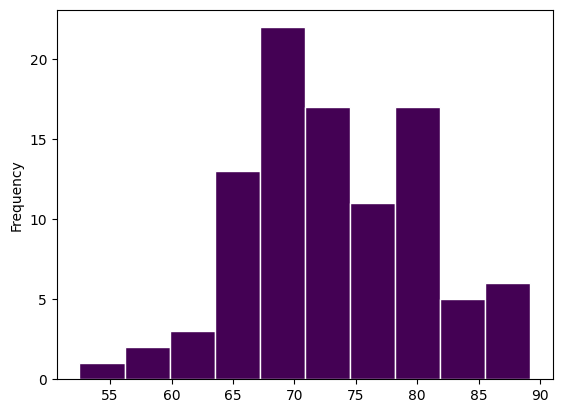

In [33]:
(fifa
 .loc[:,lambda df: ['home_team','date']+df.select_dtypes('number').columns.to_list()]
 .assign(year = lambda df: df.date.dt.year)
 .drop('date', axis=1)
#  .info()
 .groupby(by=['home_team'], as_index=False).agg('mean')
 .dropna(axis='rows')
 .set_index('home_team')
 .home_team_goalkeeper_score
 .plot.hist(bins=10, edgecolor='white', cmap='viridis')
)

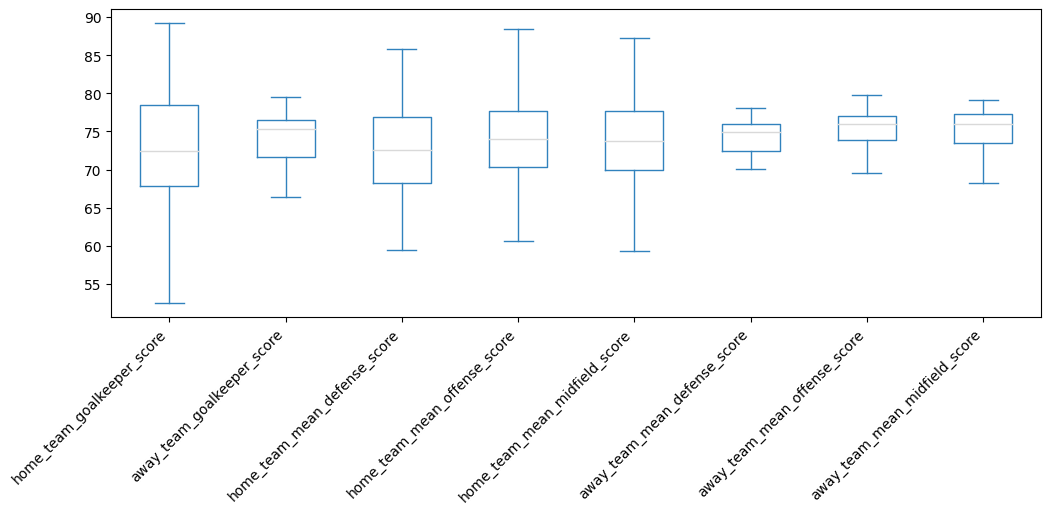

In [34]:
(fifa
 .loc[:,lambda df: ['home_team','date']+df.select_dtypes('number').columns.to_list()]
 .assign(year = lambda df: df.date.dt.year)
 .drop('date', axis=1)
#  .info()
 .groupby(by=['home_team'], as_index=False).agg('mean')
 .dropna(axis='rows')
 .set_index('home_team')
 .iloc[:,-9:-1]
 .plot.box(cmap='tab20c', figsize=(12,4), rot=45)
 .set_xticklabels(fifa.select_dtypes('number').columns[-8:], ha='right')
#  .legend(bbox_to_anchor=(1.01,1))
);

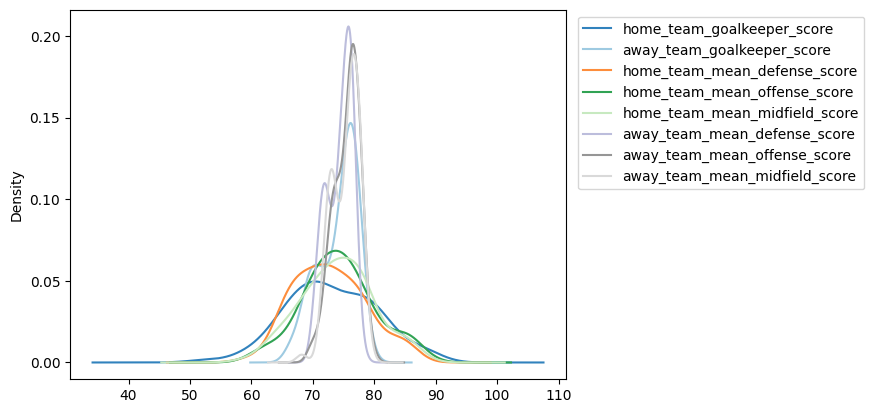

In [35]:
(fifa
 .loc[:,lambda df: ['home_team','date']+df.select_dtypes('number').columns.to_list()]
 .assign(year = lambda df: df.date.dt.year)
 .drop('date', axis=1)
#  .info()
 .groupby(by=['home_team'], as_index=False).agg('mean')
 .dropna(axis='rows')
 .set_index('home_team')
 .iloc[:,-9:-1]
 .plot.kde(cmap='tab20c')
 .legend(bbox_to_anchor=(1.01,1))
)

<AxesSubplot: xlabel='home_team'>

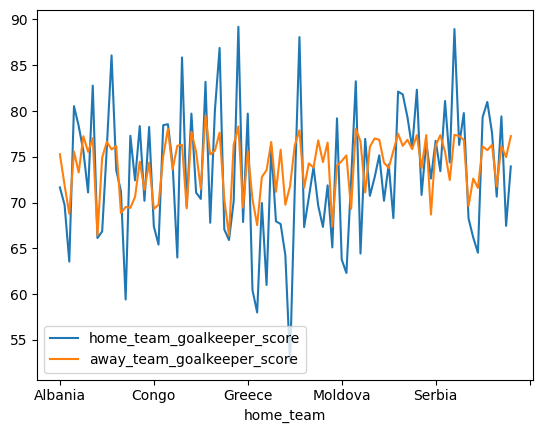

In [36]:
(fifa
 .loc[:,lambda df: ['home_team','date']+df.select_dtypes('number').columns.to_list()]
 .assign(year = lambda df: df.date.dt.year)
 .drop('date', axis=1)
#  .info()
 .groupby(by=['home_team'], as_index=False).agg('mean')
 .dropna(axis='rows')
 .set_index('home_team')
 .iloc[:,-9:-7]
 .plot()
)

<AxesSubplot: >

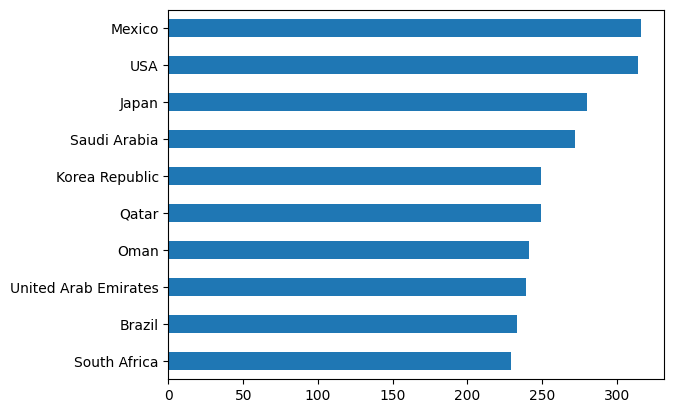

In [37]:
(fifa
 .loc[:,lambda df: ['date']+df.select_dtypes('category').columns.to_list()]
 .assign(year = lambda df: df.date.dt.year)
 .home_team.value_counts(ascending=True)
 .iloc[-10:]
 .plot.barh()
)

<AxesSubplot: ylabel='tournament'>

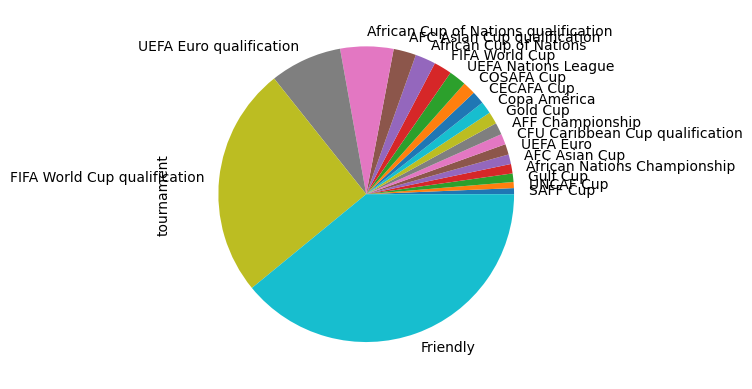

In [38]:
(fifa
 .loc[:,lambda df: ['date']+df.select_dtypes('category').columns.to_list()]
 .assign(year = lambda df: df.date.dt.year)
 .tournament.value_counts(ascending=True)
 .iloc[-20:]
 .plot.pie()
)

## Chapter 26 - Reshaping Dataframes with dummies
There are many different ways to reshape dataframes.  These patterns repeat often and will become ubiquitous with working with dataframes and interogating data. 

### Dummy Columns
Creating dummy columns is a way to encode the categorical data as numerical data.  A column which has repeated string values, you can create a column for each of these values and create a 1 or a 0 when there is an entry.  This is also called vectorizing your data, and is often seen in NLP processing when tokenizing text data to count instances of positive and negative words across a text body.

> **Note**: For demo, had to reload the jetbrains data before the tweak function application.  The raw data is almost in dummy format

In [39]:
jb_raw = pd.read_csv('2020-jetbrains-python-survey.csv') # normally pursue url

c:\users\knhoffm\.virtualenvs\python_for_engineer_science\lib\site-packages\IPython\core\interactiveshell.py:3378: DtypeWarning: Columns (152) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [40]:
jobs = (jb_raw
 .filter(like = r'job.role') #filter columns
 .where(lambda df: df.isna(), 1) # replace entries with 1s
 .fillna(0) # replace Nan with 0
 .idxmax(axis='columns') # find max value in each column for each record, which reports first job entry per record
 .str.replace('job.role.','',regex=False) # strip job.role. prefix from each entry
 # --- this is the normal starting point for a regular series you want to vectorize ---
)

pd.get_dummies(jobs) # vectorized data creates a column for every entry

Architect  Business analyst  CIO / CEO / CTO  DBA  Data analyst  \
0              0                 1                0    0             0   
1              0                 0                0    0             0   
2              0                 0                0    0             0   
3              0                 0                0    1             0   
4              0                 0                0    1             0   
...          ...               ...              ...  ...           ...   
54457          0                 0                0    0             0   
54458          0                 0                0    1             0   
54459          0                 0                1    0             0   
54460          0                 0                0    0             0   
54461          1                 0                0    0             0   

       Developer / Programmer  Other  Product manager  QA engineer  \
0                           0      0                0            0   
1                           1      0                0            0   
2                           1      0                0            0   
3                           0      0                0            0   
4                           0      0                0            0   
...                       ...    ...              ...          ...   
54457                       0      0                0            0   
54458                       0      0                0            0   
54459                       0      0                0            0   
54460                       1      0                0            0   
54461                       0      0                0            0   

       Systems analyst  Team lead  Technical support  Technical writer  
0                    0          0                  0                 0  
1                    0          0                  0                 0  
2                    0          0                  0                 0  
3                    0          0                  0                 0  
4                    0          0                  0                 0  
...                ...        ...                ...               ...  
54457                1          0                  0                 0  
54458                0          0                  0                 0  
54459                0          0                  0                 0  
54460                0          0                  0                 0  
54461                0          0                  0                 0  

[54462 rows x 13 columns]

### Undoing dummy columns (Vectorization)
Generally, it will be required to move back and forth between vectorized and unvectorized formats.  This can be facilited in two ways.  One is more pythonic, with the other is faster:
- df.idxmax(axis='columns')
- np.where(df_vectorized) with tuple output and passed to pd.Series --> see example below

In [41]:
dum_jobs = pd.get_dummies(jobs)
dum_jobs

Architect  Business analyst  CIO / CEO / CTO  DBA  Data analyst  \
0              0                 1                0    0             0   
1              0                 0                0    0             0   
2              0                 0                0    0             0   
3              0                 0                0    1             0   
4              0                 0                0    1             0   
...          ...               ...              ...  ...           ...   
54457          0                 0                0    0             0   
54458          0                 0                0    1             0   
54459          0                 0                1    0             0   
54460          0                 0                0    0             0   
54461          1                 0                0    0             0   

       Developer / Programmer  Other  Product manager  QA engineer  \
0                           0      0                0            0   
1                           1      0                0            0   
2                           1      0                0            0   
3                           0      0                0            0   
4                           0      0                0            0   
...                       ...    ...              ...          ...   
54457                       0      0                0            0   
54458                       0      0                0            0   
54459                       0      0                0            0   
54460                       1      0                0            0   
54461                       0      0                0            0   

       Systems analyst  Team lead  Technical support  Technical writer  
0                    0          0                  0                 0  
1                    0          0                  0                 0  
2                    0          0                  0                 0  
3                    0          0                  0                 0  
4                    0          0                  0                 0  
...                ...        ...                ...               ...  
54457                1          0                  0                 0  
54458                0          0                  0                 0  
54459                0          0                  0                 0  
54460                0          0                  0                 0  
54461                0          0                  0                 0  

[54462 rows x 13 columns]

In [42]:
dum_jobs.idxmax(axis='columns')

0              Business analyst
1        Developer / Programmer
2        Developer / Programmer
3                           DBA
4                           DBA
                  ...          
54457           Systems analyst
54458                       DBA
54459           CIO / CEO / CTO
54460    Developer / Programmer
54461                 Architect
Length: 54462, dtype: object

In [43]:
i,j = np.where(dum_jobs)
(i,j) # output two arrays with recod index and column position (j can only be 0 thru 12)

(array([    0,     1,     2, ..., 54459, 54460, 54461], dtype=int64),
 array([1, 5, 5, ..., 2, 5, 0], dtype=int64))

In [44]:
pd.Series(dum_jobs.columns[j], i) # make a series from column list position as the value and index position as record

0              Business analyst
1        Developer / Programmer
2        Developer / Programmer
3                           DBA
4                           DBA
                  ...          
54457           Systems analyst
54458                       DBA
54459           CIO / CEO / CTO
54460    Developer / Programmer
54461                 Architect
Length: 54462, dtype: object

### Pset
With a data set of your choice:
1. create a vectorized version of a column
2. undo the vectorized columns

In [45]:
tourny_vect = pd.get_dummies(fifa.tournament)
tourny_vect

ABCS Tournament  AFC Asian Cup  AFC Asian Cup qualification  \
0                    0              0                            0   
1                    0              0                            0   
2                    0              0                            0   
3                    0              0                            0   
4                    0              0                            0   
...                ...            ...                          ...   
23916                0              0                            0   
23917                0              0                            0   
23918                0              0                            0   
23919                0              0                            0   
23920                0              0                            0   

       AFC Challenge Cup  AFC Challenge Cup qualification  AFF Championship  \
0                      0                                0                 0   
1                      0                                0                 0   
2                      0                                0                 0   
3                      0                                0                 0   
4                      0                                0                 0   
...                  ...                              ...               ...   
23916                  0                                0                 0   
23917                  0                                0                 0   
23918                  0                                0                 0   
23919                  0                                0                 0   
23920                  0                                0                 0   

       AFF Championship qualification  African Cup of Nations  \
0                                   0                       0   
1                                   0                       0   
2                                   0                       0   
3                                   0                       0   
4                                   0                       0   
...                               ...                     ...   
23916                               0                       0   
23917                               0                       0   
23918                               0                       0   
23919                               0                       0   
23920                               0                       0   

       African Cup of Nations qualification  African Nations Championship  \
0                                         0                             0   
1                                         0                             0   
2                                         0                             0   
3                                         0                             0   
4                                         0                             0   
...                                     ...                           ...   
23916                                     0                             0   
23917                                     0                             0   
23918                                     0                             0   
23919                                     0                             0   
23920                                     0                             0   

       ...  UEFA Euro  UEFA Euro qualification  UEFA Nations League  \
0      ...          0                        0                    0   
1      ...          0                        0                    0   
2      ...          0                        0                    0   
3      ...          0                        0                    0   
4      ...          0                        0                    0   
...    ...        ...                      ...                  ...   
23916  ...    

In [46]:
tourny_vect.idxmax(axis=1)

0        FIFA World Cup qualification
1                            Friendly
2        FIFA World Cup qualification
3                            Friendly
4        FIFA World Cup qualification
                     ...             
23916             UEFA Nations League
23917             UEFA Nations League
23918                       Kirin Cup
23919                       Kirin Cup
23920                        Friendly
Length: 23921, dtype: object

In [47]:
pd.get_dummies(fifa[['home_team','country']]).idxmax(axis=1) # both conversions in one line

0               home_team_Bolivia
1                home_team_Brazil
2               home_team_Ecuador
3                home_team_Guinea
4              home_team_Paraguay
                   ...           
23916           home_team_Moldova
23917     home_team_Liechtenstein
23918             home_team_Chile
23919             home_team_Japan
23920    home_team_Korea Republic
Length: 23921, dtype: object

## Chapter 27 Reshaping by pivoting and grouping
This is one of the most powerful aspects of code based analysis.  The ability to restructure the data in an almost endless number of shapes to find insights is a powerful adaptation.  It allows a large number of use cases, include application in machine learning and visualization.  Python and pandas has developed a number of ways to approach this reshaping area.

### Pivot tables, Groupbys and cross tabs
All of these methods can be used to reshape data, and in some ways can achieve the same outcome with different methods.  It will not always be apparent which is the best option for a given reshaping target.  In some ways, the user with get more familiar with different techniques and leverage them more than others.

In [48]:
jb.info() # clean Jetbrains survey data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14321 entries, 1 to 54461
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   age                         14321 non-null  Int64   
 1   are_you_datascientist       14321 non-null  object  
 2   company_size                14321 non-null  Int64   
 3   country_live                14321 non-null  category
 4   employment_status           14321 non-null  category
 5   first_learn_about_main_ide  14321 non-null  object  
 6   how_often_use_main_ide      14321 non-null  object  
 7   ide_main                    14321 non-null  object  
 8   is_python_main              14321 non-null  category
 9   job_team                    14321 non-null  object  
 10  main_purposes               14321 non-null  object  
 11  missing_features_main_ide   14321 non-null  object  
 12  nps_main_ide                14321 non-null  float64 
 13  python_years    

### The first reshape example
Something simple to get started in the world of reshaping a cleaned dataset.  Assume the question is "What is the average age by country for each employment status?"  Breaking this into pandas type manipulations:
- put country in the index
- create a column for each employment status
- put the average age in each cell

There are three different ways to achieve this below:
1. pivot_table
2. pd.cross_tab
3. group_by

In [49]:
# this maps exactly to the pivot_table method
(jb
 .assign(age = lambda df:df.age.astype('float'))
 .pivot_table(index='country_live',columns='employment_status', values='age', aggfunc='mean')
)

employment_status  Fully employed by a company / organization  \
country_live                                                    
Algeria                                             32.666667   
Argentina                                           30.844444   
Armenia                                             22.071429   
Australia                                           33.139241   
Austria                                             31.702128   
...                                                       ...   
United States                                       32.547292   
Uruguay                                             27.812500   
Uzbekistan                                          21.000000   
Venezuela                                           29.142857   
Viet Nam                                            23.333333   

employment_status  Partially employed by a company / organization  \
country_live                                                        
Algeria                                                 24.000000   
Argentina                                               30.400000   
Armenia                                                       NaN   
Australia                                               30.400000   
Austria                                                 30.333333   
...                                                           ...   
United States                                           27.361702   
Uruguay                                                 30.250000   
Uzbekistan                                              21.000000   
Venezuela                                               28.250000   
Viet Nam                                                      NaN   

employment_status  Self-employed (a person earning income directly from one's own business, trade, or profession)  \
country_live                                                                                                        
Algeria                                                    27.000000                                                
Argentina                                                  28.454545                                                
Armenia                                                    24.000000                                                
Australia                                                  42.360000                                                
Austria                                                    35.000000                                                
...                                                              ...                                                
United States                                              39.750000                                                
Uruguay                                                    30.000000                                                
Uzbekistan                                                       NaN                                                
Venezuela                                                  29.857143                                                
Viet Nam                                                   30.750000                                                

employment_status  Working student  
country_live                        
Algeria                        NaN  
Argentina                 23.70000  
Armenia                        NaN  
Australia                 24.12500  
Austria                   25.50000  
...                            ...  
United States             21.89011  
Uruguay                        NaN  
Uzbekistan                     NaN  
Venezuela                 25.50000  
Viet Nam                  21.00000  

[76 rows x 4 columns]

In [50]:
# crosstab version of the same pivot
pd.crosstab(index=jb.country_live, columns=jb.employment_status, values=jb.age.astype('float'), aggfunc='mean')

employment_status  Fully employed by a company / organization  \
country_live                                                    
Algeria                                             32.666667   
Argentina                                           30.844444   
Armenia                                             22.071429   
Australia                                           33.139241   
Austria                                             31.702128   
...                                                       ...   
United States                                       32.547292   
Uruguay                                             27.812500   
Uzbekistan                                          21.000000   
Venezuela                                           29.142857   
Viet Nam                                            23.333333   

employment_status  Partially employed by a company / organization  \
country_live                                                        
Algeria                                                 24.000000   
Argentina                                               30.400000   
Armenia                                                       NaN   
Australia                                               30.400000   
Austria                                                 30.333333   
...                                                           ...   
United States                                           27.361702   
Uruguay                                                 30.250000   
Uzbekistan                                              21.000000   
Venezuela                                               28.250000   
Viet Nam                                                      NaN   

employment_status  Self-employed (a person earning income directly from one's own business, trade, or profession)  \
country_live                                                                                                        
Algeria                                                    27.000000                                                
Argentina                                                  28.454545                                                
Armenia                                                    24.000000                                                
Australia                                                  42.360000                                                
Austria                                                    35.000000                                                
...                                                              ...                                                
United States                                              39.750000                                                
Uruguay                                                    30.000000                                                
Uzbekistan                                                       NaN                                                
Venezuela                                                  29.857143                                                
Viet Nam                                                   30.750000                                                

employment_status  Working student  
country_live                        
Algeria                        NaN  
Argentina                 23.70000  
Armenia                        NaN  
Australia                 24.12500  
Austria                   25.50000  
...                            ...  
United States             21.89011  
Uruguay                        NaN  
Uzbekistan                     NaN  
Venezuela                 25.50000  
Viet Nam                  21.00000  

[76 rows x 4 columns]

In [51]:
(jb
 .assign(age = lambda df:df.age.astype('float'))
 .groupby(['country_live','employment_status'])
 .age
 .mean()
 .unstack()
 .dropna(how='all', axis=1)
)

employment_status  Fully employed by a company / organization  \
country_live                                                    
Algeria                                             32.666667   
Argentina                                           30.844444   
Armenia                                             22.071429   
Australia                                           33.139241   
Austria                                             31.702128   
...                                                       ...   
United States                                       32.547292   
Uruguay                                             27.812500   
Uzbekistan                                          21.000000   
Venezuela                                           29.142857   
Viet Nam                                            23.333333   

employment_status  Partially employed by a company / organization  \
country_live                                                        
Algeria                                                 24.000000   
Argentina                                               30.400000   
Armenia                                                       NaN   
Australia                                               30.400000   
Austria                                                 30.333333   
...                                                           ...   
United States                                           27.361702   
Uruguay                                                 30.250000   
Uzbekistan                                              21.000000   
Venezuela                                               28.250000   
Viet Nam                                                      NaN   

employment_status  Self-employed (a person earning income directly from one's own business, trade, or profession)  \
country_live                                                                                                        
Algeria                                                    27.000000                                                
Argentina                                                  28.454545                                                
Armenia                                                    24.000000                                                
Australia                                                  42.360000                                                
Austria                                                    35.000000                                                
...                                                              ...                                                
United States                                              39.750000                                                
Uruguay                                                    30.000000                                                
Uzbekistan                                                       NaN                                                
Venezuela                                                  29.857143                                                
Viet Nam                                                   30.750000                                                

employment_status  Working student  
country_live                        
Algeria                        NaN  
Argentina                 23.70000  
Armenia                        NaN  
Australia                 24.12500  
Austria                   25.50000  
...                            ...  
United States             21.89011  
Uruguay                        NaN  
Uzbekistan                     NaN  
Venezuela                 25.50000  
Viet Nam                  21.00000  

[76 rows x 4 columns]

<AxesSubplot: >

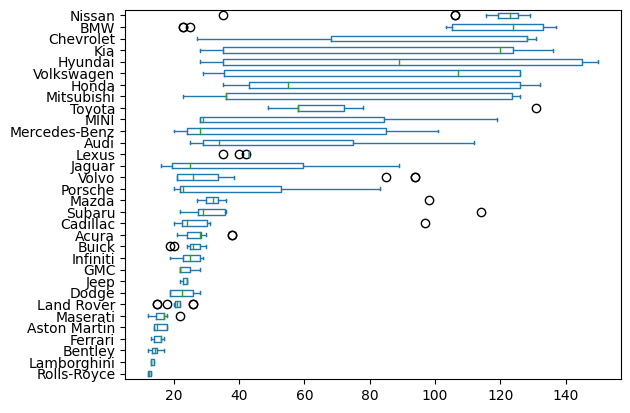

In [52]:
(cars
 .pivot_table(index='year',columns='make', values='city08', aggfunc='max')
 .loc[2010:]
 .dropna(axis=1).T
 .assign(avg = lambda df: df.mean(axis=1))
 .sort_values(by='avg').T
 .plot.box(vert=False)
)

<AxesSubplot: >

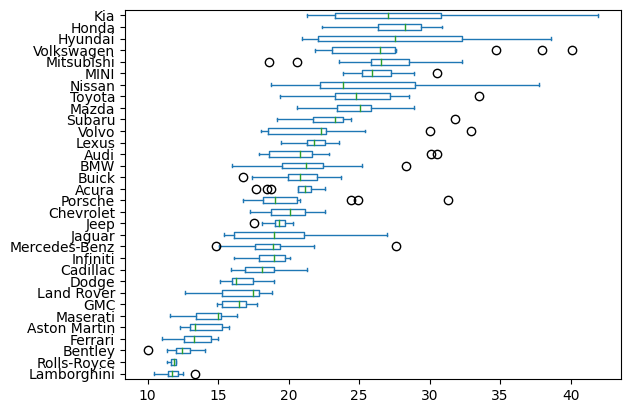

In [53]:
(pd.crosstab(aggfunc='mean', index=cars.year, columns=cars.make, values=cars.city08)
 .loc[2010:]
 .dropna(axis=1).T
 .assign(avg = lambda df: df.mean(axis=1))
 .sort_values(by='avg').T
 .plot.box(vert=False)
)

<AxesSubplot: >

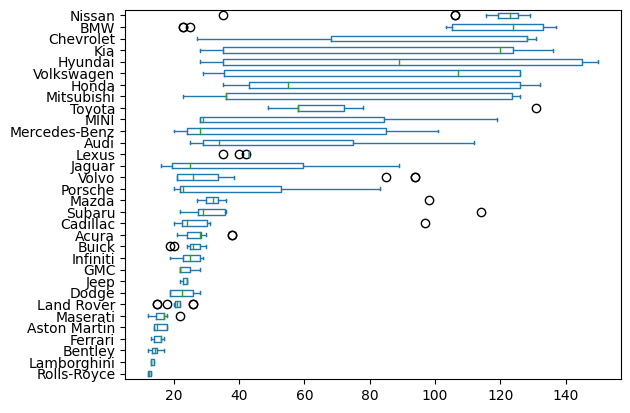

In [54]:
(cars
 .groupby(['year', 'make'])
 .city08
 .max()
 .unstack()  # everything beyond this point is the same in all three plots
 .loc[2010:]
 .dropna(axis=1).T
 .assign(avg = lambda df: df.mean(axis=1))
 .sort_values(by='avg').T
 .plot.box(vert=False)
)

### Using a custom aggregation function
In some instances, the default aggregation options will not be able to satisfy a given inquiry.  A question like, "What is the percentage of Emacs users by country?" would trip up the basic mean, median, max, min, sum and count options.  For those cases, a custom function can be defined for the aggregation.   

In [55]:
def per_emacs(ser):
    '''Find the Emacs records, sum the Boolean return and divide by the original series length.'''
    return ser.str.contains('Emacs').mean()*100

In [56]:
per_emacs(jb.ide_main)

3.0305146288666993

In [57]:
(jb
 .pivot_table(index='country_live', values='ide_main', aggfunc=per_emacs)
)

ide_main
country_live           
Algeria        0.000000
Argentina      3.448276
Armenia        0.000000
Australia      3.571429
Austria        1.526718
...                 ...
United States  4.407514
Uruguay        0.000000
Uzbekistan     0.000000
Venezuela      0.000000
Viet Nam       0.000000

[76 rows x 1 columns]

In [58]:
pd.crosstab(index=jb.country_live, columns=jb.assign(iden='emac_per').iden, values=jb.ide_main, aggfunc=per_emacs)

iden           emac_per
country_live           
Algeria        0.000000
Argentina      3.448276
Armenia        0.000000
Australia      3.571429
Austria        1.526718
...                 ...
United States  4.407514
Uruguay        0.000000
Uzbekistan     0.000000
Venezuela      0.000000
Viet Nam       0.000000

[76 rows x 1 columns]

In [59]:
(jb
  .groupby('country_live')
 [['ide_main']]
#  .count()
 .agg(per_emacs)
)

ide_main
country_live           
Algeria        0.000000
Argentina      3.448276
Armenia        0.000000
Australia      3.571429
Austria        1.526718
...                 ...
United States  4.407514
Uruguay        0.000000
Uzbekistan     0.000000
Venezuela      0.000000
Viet Nam       0.000000

[76 rows x 1 columns]

### Multiple Aggregations
When there is a need for multiple aggregations, which is often the case, pandas has the functionality built into each of the types being applied.  That said, the crosstab method is really intended for compairing one column against another, and not intended for this type of aggregation.  It has to be forced to work.

In [60]:
(cars
 [['make','year','cylinders','drive']]
 .groupby('make')
 .agg(['max','min'])
)

year       cylinders     
                              max   min       max  min
make                                                  
AM General                   1985  1984       6.0  4.0
ASC Incorporated             1987  1987       6.0  6.0
Acura                        2023  1986       6.0  4.0
Alfa Romeo                   2023  1984       8.0  4.0
American Motors Corporation  1987  1984       6.0  4.0
...                           ...   ...       ...  ...
Volkswagen                   2023  1984      12.0  4.0
Volvo                        2023  1984       8.0  4.0
Wallace Environmental        1992  1991      12.0  4.0
Yugo                         1990  1986       4.0  4.0
smart                        2019  2008       3.0  3.0

[141 rows x 4 columns]

In [61]:
# What is the minimum and maximum age for each country
(jb
 .pivot_table(index='country_live',values='age', aggfunc=('max', 'min'))
)

max min
country_live         
Algeria        60  18
Argentina      60  18
Armenia        30  18
Australia      60  18
Austria        50  18
...            ..  ..
United States  60  18
Uruguay        40  21
Uzbekistan     21  21
Venezuela      50  18
Viet Nam       60  18

[76 rows x 2 columns]

In [62]:
# What is the minimum and maximum age for each country
(jb
 .groupby('country_live')
 [['age']]
 .agg(['max', 'min'])
)

age    
              max min
country_live         
Algeria        60  18
Argentina      60  18
Armenia        30  18
Australia      60  18
Austria        50  18
...            ..  ..
United States  60  18
Uruguay        40  21
Uzbekistan     21  21
Venezuela      50  18
Viet Nam       60  18

[76 rows x 2 columns]

### Per Column aggregations
As an extension of this aggregation process, it is possible to specify which aggregation is needed for specific columns.  This allows multiple numeric columns to be aggregated in different ways within the same structure.  It also allows multiple aggregations per column if desired.

In [63]:
(jb
 .pivot_table(index='country_live', aggfunc=('min','max'))
 .select_dtypes('number')
)

nps_main_ide      python3_ver      team_size      \
                       max  min         max  min       max min   
country_live                                                     
Algeria               10.0  1.0         3.9  3.5        10   1   
Argentina             10.0  4.0         3.9  3.6        21   0   
Armenia               10.0  7.0         3.9  3.6        13   1   
Australia             10.0  0.0         3.9  3.5        41   1   
Austria               10.0  3.0         3.9  3.5        13   1   
...                    ...  ...         ...  ...       ...  ..   
United States         10.0  0.0         3.9  3.5        41   1   
Uruguay               10.0  7.0         3.8  3.6        13   2   
Uzbekistan            10.0  9.0         3.8  3.6         5   1   
Venezuela             10.0  3.0         3.9  3.5        21   1   
Viet Nam              10.0  5.0         3.9  3.5        41   1   

              years_of_coding       
                          max  min  
country_live                        
Algeria                  11.0  1.0  
Argentina                11.0  1.0  
Armenia                  11.0  1.0  
Australia                11.0  1.0  
Austria                  11.0  1.0  
...                       ...  ...  
United States            11.0  1.0  
Uruguay                  11.0  1.0  
Uzbekistan                6.0  1.0  
Venezuela                11.0  1.0  
Viet Nam                 11.0  1.0  

[76 rows x 8 columns]

In [64]:
(jb
 .groupby('country_live')
 .agg(['min','max'])
 .select_dtypes('number')
)

age     company_size       nps_main_ide       team_size      \
              min max          min   max          min   max       min max   
country_live                                                                
Algeria        18  60            1  5000          1.0  10.0         1  10   
Argentina      18  60            1  5000          4.0  10.0         0  21   
Armenia        18  30            1  5000          7.0  10.0         1  13   
Australia      18  60            1  5000          0.0  10.0         1  41   
Austria        18  50            1  5000          3.0  10.0         1  13   
...            ..  ..          ...   ...          ...   ...       ...  ..   
United States  18  60            1  5000          0.0  10.0         1  41   
Uruguay        21  40            2  5000          7.0  10.0         2  13   
Uzbekistan     21  21            1  5000          9.0  10.0         1   5   
Venezuela      18  50            1  5000          3.0  10.0         1  21   
Viet Nam       18  60            1  5000          5.0  10.0         1  41   

              years_of_coding       python3_ver       
                          min   max         min  max  
country_live                                          
Algeria                   1.0  11.0         3.5  3.9  
Argentina                 1.0  11.0         3.6  3.9  
Armenia                   1.0  11.0         3.6  3.9  
Australia                 1.0  11.0         3.5  3.9  
Austria                   1.0  11.0         3.5  3.9  
...                       ...   ...         ...  ...  
United States             1.0  11.0         3.5  3.9  
Uruguay                   1.0  11.0         3.6  3.8  
Uzbekistan                1.0   6.0         3.6  3.8  
Venezuela                 1.0  11.0         3.5  3.9  
Viet Nam                  1.0  11.0         3.5  3.9  

[76 rows x 12 columns]

In [65]:
# what are the min and max ages and average team sizes per country
(jb
 .pivot_table(index='country_live', aggfunc={'age':['min','max'], 'team_size':'mean'})
 .assign(team_size = lambda df:df.team_size.round(0))
)

age     team_size
              max min      mean
country_live                   
Algeria        60  18       3.0
Argentina      60  18       4.0
Armenia        30  18       4.0
Australia      60  18       3.0
Austria        50  18       3.0
...            ..  ..       ...
United States  60  18       4.0
Uruguay        40  21       4.0
Uzbekistan     21  21       2.0
Venezuela      50  18       3.0
Viet Nam       60  18       4.0

[76 rows x 3 columns]

In [66]:
# what are the min and max ages and average team sizes per country
(jb
 .groupby('country_live')
 .agg({'age':['min','max'], 'team_size':'mean'})
 .assign(team_size = lambda df:df.team_size.round(0))
)

age     team_size
              min max      mean
country_live                   
Algeria        18  60       3.0
Argentina      18  60       4.0
Armenia        18  30       4.0
Australia      18  60       3.0
Austria        18  50       3.0
...            ..  ..       ...
United States  18  60       4.0
Uruguay        21  40       4.0
Uzbekistan     21  21       2.0
Venezuela      18  50       3.0
Viet Nam       18  60       4.0

[76 rows x 3 columns]

### Hiearchical Columns vs Named Aggregations
One challenging aspect of the results above is the hierarchy created by the grouping/aggregation techniques.  This is sometimes problematice when trying to leverage the data in other ways or present the information.  One specific way to address this is only available in the groupby API, called named aggregations.  This is not available in any of the other grouping options.

Groupby **Named aggregations** allow the user to specify the name of the resulting aggregation in a similar nature to the assign function.  The removes the aggregated view to help with the presentation capability or even reuse of the data.

In [67]:
(jb
 .groupby('country_live')
 .agg(age_max = ('age','max'),
      age_min = ('age','min'),
      team_size_avg = ('team_size','mean'),
      team_size_med = ('team_size','median'))
 .astype(int)
)

age_max  age_min  team_size_avg  team_size_med
country_live                                                 
Algeria             60       18              3              2
Argentina           60       18              4              2
Armenia             30       18              4              2
Australia           60       18              3              2
Austria             50       18              3              2
...                ...      ...            ...            ...
United States       60       18              4              2
Uruguay             40       21              3              2
Uzbekistan          21       21              2              2
Venezuela           50       18              3              2
Viet Nam            60       18              4              2

[76 rows x 4 columns]

### Hierachical Indexes
Although annoying in some instances, they have thier uses.  It usually comes in the form of a multilevel question.  Something like what is the min and max age for each country and editor.  This now requires a stacked index.

In [68]:
(jb
 .pivot_table(index=['country_live','ide_main'], aggfunc=[min, max], values='age')
 .swaplevel(axis=1) # puts the min max under age as opposed to the opposite version
)

age    
                                          min max
country_live ide_main                            
Algeria      Atom                          21  60
             Eclipse + Pydev               18  18
             IDLE                          40  40
             Jupyter Notebook              30  30
             Other                         30  30
...                                        ..  ..
Viet Nam     Other                         21  21
             PyCharm Community Edition     21  30
             PyCharm Professional Edition  21  30
             VS Code                       18  30
             Vim                           21  40

[830 rows x 2 columns]

In [69]:
(jb
 .groupby(by=['country_live','ide_main'], observed=True) # observed = True avoids empty records
 .agg(age_max=('age','max'),age_min=('age','min'))
 .sort_index()
)

age_max  age_min
country_live ide_main                                      
Algeria      Atom                               60       21
             Eclipse + Pydev                    18       18
             IDLE                               40       40
             Jupyter Notebook                   30       30
             Other                              30       30
...                                            ...      ...
Viet Nam     Other                              21       21
             PyCharm Community Edition          30       21
             PyCharm Professional Edition       30       21
             VS Code                            30       18
             Vim                                40       21

[830 rows x 2 columns]

In [70]:
(cars
 [['make','year','cylinders','drive']]
 .groupby(by=['make','year'])
 [['cylinders']]
 .agg('max')
 .reset_index()
)

make  year  cylinders
0           AM General  1984        6.0
1           AM General  1985        6.0
2     ASC Incorporated  1987        6.0
3                Acura  1986        6.0
4                Acura  1987        6.0
...                ...   ...        ...
1905             smart  2015        3.0
1906             smart  2016        3.0
1907             smart  2017        3.0
1908             smart  2018        NaN
1909             smart  2019        NaN

[1910 rows x 3 columns]

### Grouping with Functions
Sometimes the standard aggregations are not quite the aggregation needed to summarize the data.  In these cases you can actually create a grouping basis column and leverage it to group the data.  The column creation can be direct or done through a function call to make the code more concise, which both pivot_table and groupby allow as their aggregation level.

In [71]:
def even_grouper(idx):
    '''Create boolean column based on index value'''
    return 'odd' if idx%2 else 'even'

In [72]:
(jb
 .pivot_table(index=even_grouper, aggfunc='size')
)

even    7156
odd     7165
dtype: int64

In [73]:
(jb
 .groupby(even_grouper)
 .size()
)

even    7156
odd     7165
dtype: int64

### Pset
With a dataset of your choice:
1. group by a categorical column and take the mean of the numeric columns
2. group by a categorical column and take the mean and the max of the numeric columns
3. group by a categorical column and apply a custom aggregation that takes the mode of the numeric columns
4. group by two categorical column and take the mean of the numeric columns
5. group by a binned numeric column and take the mean of the numeric columns

In [74]:
(fifa
 .groupby(by='home_team')
 .mean()
)

home_team_fifa_rank  away_team_fifa_rank  \
home_team                                                  
Afghanistan              157.527778           151.194444   
Albania                   76.572519            68.129771   
Algeria                   54.496855            76.823899   
American Samoa           200.000000           178.294118   
Andorra                  165.721649            70.670103   
...                             ...                  ...   
Vietnam                  122.733333           124.875000   
Wales                     53.891473            50.558140   
Yemen                    143.919540           109.057471   
Zambia                    57.944444            88.622222   
Zimbabwe                  86.933333            99.970370   

                home_team_total_fifa_points  away_team_total_fifa_points  \
home_team                                                                  
Afghanistan                      278.500000                   280.972222   
Albania                          377.564885                   369.297710   
Algeria                          418.943396                   323.459119   
American Samoa                   161.235294                   190.647059   
Andorra                          276.536082                   464.546392   
...                                     ...                          ...   
Vietnam                          239.991667                   232.908333   
Wales                            502.666667                   470.193798   
Yemen                            129.781609                   186.356322   
Zambia                           270.322222                   237.966667   
Zimbabwe                         205.140741                   206.785185   

                home_team_score  away_team_score  neutral_location  \
home_team                                                            
Afghanistan            1.416667         1.472222          0.944444   
Albania                1.190840         1.091603          0.152672   
Algeria                1.867925         0.899371          0.314465   
American Samoa         1.000000         5.529412          1.000000   
Andorra                0.371134         2.051546          0.195876   
...                         ...              ...               ...   
Vietnam                1.875000         1.150000          0.225000   
Wales                  1.240310         1.038760          0.093023   
Yemen                  1.149425         1.425287          0.494253   
Zambia                 1.444444         0.744444          0.333333   
Zimbabwe               1.518519         0.800000          0.192593   

                home_team_goalkeeper_score  away_team_goalkeeper_score  \
home_team                                                                
Afghanistan                            NaN                   64.000000   
Albania                          71.653846                   75.281250   
Algeria                          69.743243                   71.888889   
American Samoa                         NaN                         NaN   
Andorra                                NaN                   75.568627   
...                                    ...                         ...   
Vietnam                          64.000000                   70.307692   
Wales                            73.946237                   77.256410   
Yemen                                  NaN                   72.000000   
Zambia                                 NaN                   68.757576   
Zimbabwe                               NaN                   68.681818   

                home_team_mean_defense_score  home_team_mean_offense_score  \
home_team                                                                    
Afghanistan                              NaN                           NaN   
Albania                            72.958140                     68.295652   
Algeria                            74.178125                

In [75]:
(fifa
 .groupby(by='home_team')
 .agg(['mean','max'])
 .select_dtypes('number')
)

home_team_fifa_rank      away_team_fifa_rank       \
                              mean  max                mean  max   
home_team                                                          
Afghanistan             157.527778  198          151.194444  207   
Albania                  76.572519  124           68.129771  209   
Algeria                  54.496855  103           76.823899  187   
American Samoa          200.000000  204          178.294118  205   
Andorra                 165.721649  205           70.670103  209   
...                            ...  ...                 ...  ...   
Vietnam                 122.733333  172          124.875000  200   
Wales                    53.891473  117           50.558140  205   
Yemen                   143.919540  186          109.057471  198   
Zambia                   57.944444   99           88.622222  188   
Zimbabwe                 86.933333  131           99.970370  202   

               home_team_total_fifa_points       away_team_total_fifa_points  \
                                      mean   max                        mean   
home_team                                                                      
Afghanistan                     278.500000  1068                  280.972222   
Albania                         377.564885  1384                  369.297710   
Algeria                         418.943396  1516                  323.459119   
American Samoa                  161.235294   908                  190.647059   
Andorra                         276.536082  1120                  464.546392   
...                                    ...   ...                         ...   
Vietnam                         239.991667  1260                  232.908333   
Wales                           502.666667  1588                  470.193798   
Yemen                           129.781609  1106                  186.356322   
Zambia                          270.322222  1316                  237.966667   
Zimbabwe                        205.140741  1192                  206.785185   

                     home_team_score      ... home_team_mean_offense_score  \
                 max            mean max  ...                         mean   
home_team                                 ...                                
Afghanistan     1391        1.416667   5  ...                          NaN   
Albania         1726        1.190840   6  ...                    68.295652   
Algeria         1622        1.867925   8  ...                    75.181373   
American Samoa  1026        1.000000   8  ...                          NaN   
Andorra         1755        0.371134   2  ...                          NaN   
...              ...             ...  ..  ...                          ...   
Vietnam         1517        1.875000  11  ...                          NaN   
Wales           1832        1.240310   6  ...                    74.244086   
Yemen           1342        1.149425   7  ...                          NaN   
Zambia          1515        1.444444   6  ...                    67.803390   
Zimbabwe        1424        1.518519   6  ...                    69.325000   

                     home_team_mean_midfield_score        \
                 max                          mean   max   
home_team                                                  
Afghanistan      NaN                           NaN   NaN   
Albania         70.3                     71.768478  75.0   
Algeria         82.0                     74.925490  81.5   
American Samoa   NaN                           NaN   NaN   
Andorra          NaN                           NaN   NaN   
...              ...                           ...   ...   
Vietnam          NaN                           NaN   NaN   
Wales           82.3                     78.447312  80.8   
Yemen            NaN                           NaN   NaN   
Zambia          72.3                     61.461905  63.2   
Zimbabwe        72.3                     63.953968  72.8   

       

In [76]:
def mode(df):
    return df.mode()

In [77]:
(fifa
 .groupby(by='home_team', observed=True)
 .agg(mode)
 .sort_index()
#  .info()
)

date  \
home_team                                                           
Afghanistan     [2003-11-23 00:00:00, 2006-04-03 00:00:00, 200...   
Albania         [1993-09-08 00:00:00, 1993-09-22 00:00:00, 199...   
Algeria         [1993-10-08 00:00:00, 1994-10-14 00:00:00, 199...   
American Samoa  [2000-06-14 00:00:00, 2001-04-09 00:00:00, 200...   
Andorra         [1998-06-03 00:00:00, 1998-06-24 00:00:00, 199...   
...                                                           ...   
Vietnam         [1995-01-04 00:00:00, 1996-08-04 00:00:00, 199...   
Wales           [1993-10-13 00:00:00, 1993-11-17 00:00:00, 199...   
Yemen           [1996-01-26 00:00:00, 1997-05-09 00:00:00, 199...   
Zambia          [1993-09-26 00:00:00, 1994-03-12 00:00:00, 199...   
Zimbabwe        [1993-08-08 00:00:00, 1993-09-19 00:00:00, 199...   

                                                        away_team  \
home_team                                                           
Afghanistan                                          Turkmenistan   
Albania                                                   Georgia   
Algeria                                              Burkina Faso   
American Samoa                                              Tonga   
Andorra         ['Armenia', 'Moldova']
Categories (211, object...   
...                                                           ...   
Vietnam                                                  Malaysia   
Wales           ['Belgium', 'Republic of Ireland']
Categories ...   
Yemen                                                Saudi Arabia   
Zambia                                                   Zimbabwe   
Zimbabwe                                                   Zambia   

               home_team_continent away_team_continent home_team_fifa_rank  \
home_team                                                                    
Afghanistan                   Asia                Asia          [149, 150]   
Albania                     Europe              Europe                  66   
Algeria                     Africa              Africa                  38   
American Samoa             Oceania             Oceania                 203   
Andorra                     Europe              Europe                 203   
...                            ...                 ...                 ...   
Vietnam                       Asia                Asia                  98   
Wales                       Europe              Europe            [18, 19]   
Yemen                         Asia                Asia                 135   
Zambia                      Africa              Africa                  60   
Zimbabwe                    Africa              Africa      [67, 110, 115]   

                                      away_team_fifa_rank  \
home_team                                                   
Afghanistan                          [156, 167, 171, 182]   
Albania                                                14   
Algeria                                         [79, 108]   
American Samoa                            [167, 178, 197]   
Andorra                                   [3, 6, 16, 101]   
...                                                   ...   
Vietnam                                               109   
Wales                                         [2, 10, 29]   
Yemen                                                 165   
Zambia          [22, 52, 57, 84, 107, 114, 115, 121, 131]   
Zimbabwe                                         [67, 80]   

               home_team_total_fifa_points away_team_total_fifa_points  \
home_team                                                                
Afghanistan                              0                           0   
Albania                                  0                           0   
Algeria                                  0                           0   
American Samoa                           0                           0   
Andorra     

In [78]:
(fifa
 .groupby(by=['home_team','tournament'], observed=True)
 .mean()
 [['home_team_score','away_team_score']]
)

home_team_score  away_team_score
home_team tournament                                                    
Bolivia   FIFA World Cup qualification         1.750000         1.140625
          Friendly                             1.550000         0.950000
          Kirin Cup                            0.000000         2.000000
          FIFA World Cup                       1.000000         3.000000
          Confederations Cup                   2.000000         2.000000
...                                                 ...              ...
Kosovo    UEFA Nations League                  1.750000         0.875000
Gibraltar FIFA World Cup qualification         0.222222         4.111111
          Friendly                             0.250000         0.250000
          UEFA Euro qualification              0.750000         4.000000
          UEFA Nations League                  1.000000         1.857143

[1539 rows x 2 columns]

In [79]:
def binned(col):
    return pd.cut(col, 20)

In [80]:
(fifa
 .groupby(binned(fifa.home_team_fifa_rank), observed=True)
 [['home_team_score','away_team_score']]
 .mean()
)

home_team_score  away_team_score
home_team_fifa_rank                                  
(0.79, 11.5]                2.092025         0.764040
(11.5, 22.0]                1.841629         0.824535
(22.0, 32.5]                1.750000         0.863379
(32.5, 43.0]                1.678590         0.912440
(43.0, 53.5]                1.673598         0.937618
(53.5, 64.0]                1.624702         0.997613
(64.0, 74.5]                1.627329         0.963423
(74.5, 85.0]                1.580482         1.015209
(85.0, 95.5]                1.516104         1.042178
(95.5, 106.0]               1.510580         0.956314
(106.0, 116.5]              1.392915         1.151369
(116.5, 127.0]              1.382887         1.167675
(127.0, 137.5]              1.430769         1.184615
(137.5, 148.0]              1.446602         1.344121
(148.0, 158.5]              1.475943         1.418726
(158.5, 169.0]              1.500741         1.441481
(169.0, 179.5]              1.351670         1.693517
(179.5, 190.0]              1.114537         1.876652
(190.0, 200.5]              1.062271         2.322344
(200.5, 211.0]              0.701493         3.124378

## Chapter 28 More aggregations
In this chapter the goal is to dive a little deeper into aggregations, exploring the .transform() and .filter() methods available in the pandas library.

### Aggregations while keeping rows
When exploring aggregations in a dataset, it is not uncomming to want the aggregation in the original structure of the dataframe.  In these instances, the .transform() method allows a groupby call to return the original structure.  This will only work with groupby() from the prior chapter, and the aforementioned pivot_table() and cross_tab() do not allow for this type of behavior.

---
Assume you want to get the count of responses from each country.  This could be done with a groupby and then merged back into the original dataframe, but the .transform() method allows this to be conducted directly on the original groupby() call.

In [81]:
# returning the count of respondants from each country in the original dataframe structure
(jb
 .groupby('country_live')
 .age
 .transform('size') # creates a repeated aggregated value at each entry, see 2 & 11 below
)

1        1131
2        2768
5         699
10        372
11       2768
         ... 
54456     104
54457     523
54459     523
54460     308
54461      20
Name: age, Length: 14321, dtype: int64

In [82]:
# create a new column in the original dataframe
(jb
 .assign(country_responses = (jb.groupby('country_live').age.transform('size')))
)

age are_you_datascientist  company_size        country_live  \
1       21                  True          5000               India   
2       30                 False          5000       United States   
5       21                 False             1              France   
10      21                 False            51       Other country   
11      21                  True            51       United States   
...    ...                   ...           ...                 ...   
54456   30                 False          1001              Turkey   
54457   21                 False             2  Russian Federation   
54459   21                 False             1  Russian Federation   
54460   30                  True            51               Spain   
54461   21                 False            11             Algeria   

                                       employment_status  \
1             Fully employed by a company / organization   
2             Fully employed by a company / organization   
5                                        Working student   
10            Fully employed by a company / organization   
11            Fully employed by a company / organization   
...                                                  ...   
54456         Fully employed by a company / organization   
54457         Fully employed by a company / organization   
54459  Self-employed (a person earning income directl...   
54460         Fully employed by a company / organization   
54461         Fully employed by a company / organization   

                      first_learn_about_main_ide how_often_use_main_ide  \
1                            School / University                  Daily   
2                             Friend / Colleague                  Daily   
5                            School / University                 Weekly   
10                           School / University                  Daily   
11      Online learning platform / Online course                  Daily   
...                                          ...                    ...   
54456                         Friend / Colleague                  Daily   
54457                        School / University                  Daily   
54459                         Friend / Colleague                  Daily   
54460                             Search engines                  Daily   
54461   Online learning platform / Online course                  Daily   

                           ide_main                            is_python_main  \
1                           VS Code                                       Yes   
2                               Vim                                       Yes   
5      PyCharm Professional Edition  No, I use Python as a secondary language   
10                    IntelliJ IDEA                                       Yes   
11        PyCharm Community Edition                                       Yes   
...                             ...                                       ...   
54456     PyCharm Community Edition                                       Yes   
54457                           Vim                                       Yes   
54459  PyCharm Professional Edition                                       Yes   
54460                         Other                                       Yes   
54461                       VS Code                                       Yes   

                                        job_team  ...  \
1                                 Work in a team  ...   
2      Work on your own project(s) independently  ...   
5      Work on your own project(s) independently  ...   
10                                Work in a team  ...   
11                                Work in a team  ...   
...                                          ...  ...   
54456  Work on your own project(s) independently  ...   
54457  Work on your own project(s) independently  ...   
54459                             Work in a team  ...   
5

### Filtering parts of groups
Grouping methods allows us to aggregate by certain columns, and generally the returned dataframe is a collapsed view of the original version aggregated to the level perferred for our needs.  The use of .transform() method allows the original index to be maintained while still return some form of an aggregated value.  The .filter() method allows further refinement, allowing filtering of parts of groups after the aggregation.

---
Using the jetbrains survey data, Remove and row where the size of the country response is less than the median.

In [83]:
(jb
 .country_live
 .value_counts()
 .median()
)

65.0

In [84]:
# using our existing pandas approaches
c2r = (jb
 .country_live
 .value_counts()
 .ge(65)
 .index
)

In [85]:
(jb.query('country_live.isin(@c2r)'))

age are_you_datascientist  company_size        country_live  \
1       21                  True          5000               India   
2       30                 False          5000       United States   
5       21                 False             1              France   
10      21                 False            51       Other country   
11      21                  True            51       United States   
...    ...                   ...           ...                 ...   
54456   30                 False          1001              Turkey   
54457   21                 False             2  Russian Federation   
54459   21                 False             1  Russian Federation   
54460   30                  True            51               Spain   
54461   21                 False            11             Algeria   

                                       employment_status  \
1             Fully employed by a company / organization   
2             Fully employed by a company / organization   
5                                        Working student   
10            Fully employed by a company / organization   
11            Fully employed by a company / organization   
...                                                  ...   
54456         Fully employed by a company / organization   
54457         Fully employed by a company / organization   
54459  Self-employed (a person earning income directl...   
54460         Fully employed by a company / organization   
54461         Fully employed by a company / organization   

                      first_learn_about_main_ide how_often_use_main_ide  \
1                            School / University                  Daily   
2                             Friend / Colleague                  Daily   
5                            School / University                 Weekly   
10                           School / University                  Daily   
11      Online learning platform / Online course                  Daily   
...                                          ...                    ...   
54456                         Friend / Colleague                  Daily   
54457                        School / University                  Daily   
54459                         Friend / Colleague                  Daily   
54460                             Search engines                  Daily   
54461   Online learning platform / Online course                  Daily   

                           ide_main                            is_python_main  \
1                           VS Code                                       Yes   
2                               Vim                                       Yes   
5      PyCharm Professional Edition  No, I use Python as a secondary language   
10                    IntelliJ IDEA                                       Yes   
11        PyCharm Community Edition                                       Yes   
...                             ...                                       ...   
54456     PyCharm Community Edition                                       Yes   
54457                           Vim                                       Yes   
54459  PyCharm Professional Edition                                       Yes   
54460                         Other                                       Yes   
54461                       VS Code                                       Yes   

                                        job_team  \
1                                 Work in a team   
2      Work on your own project(s) independently   
5      Work on your own project(s) independently   
10                                Work in a team   
11                                Work in a team   
...                                          ...   
54456  Work on your own project(s) independently   
54457  Work on your own project(s) independently   
54459                             Work in a team   
54460  Work on your own project(s) independently   

In [86]:
# using filter method, cannot reconcile difference between methods, but filter is probably correct
(jb
 .groupby('country_live')
 .filter(lambda gdf: gdf.country_live.size >= 65)
)

age are_you_datascientist  company_size        country_live  \
1       21                  True          5000               India   
2       30                 False          5000       United States   
5       21                 False             1              France   
10      21                 False            51       Other country   
11      21                  True            51       United States   
...    ...                   ...           ...                 ...   
54450   30                 False            51       United States   
54456   30                 False          1001              Turkey   
54457   21                 False             2  Russian Federation   
54459   21                 False             1  Russian Federation   
54460   30                  True            51               Spain   

                                       employment_status  \
1             Fully employed by a company / organization   
2             Fully employed by a company / organization   
5                                        Working student   
10            Fully employed by a company / organization   
11            Fully employed by a company / organization   
...                                                  ...   
54450         Fully employed by a company / organization   
54456         Fully employed by a company / organization   
54457         Fully employed by a company / organization   
54459  Self-employed (a person earning income directl...   
54460         Fully employed by a company / organization   

                      first_learn_about_main_ide how_often_use_main_ide  \
1                            School / University                  Daily   
2                             Friend / Colleague                  Daily   
5                            School / University                 Weekly   
10                           School / University                  Daily   
11      Online learning platform / Online course                  Daily   
...                                          ...                    ...   
54450                         Friend / Colleague                  Daily   
54456                         Friend / Colleague                  Daily   
54457                        School / University                  Daily   
54459                         Friend / Colleague                  Daily   
54460                             Search engines                  Daily   

                           ide_main                            is_python_main  \
1                           VS Code                                       Yes   
2                               Vim                                       Yes   
5      PyCharm Professional Edition  No, I use Python as a secondary language   
10                    IntelliJ IDEA                                       Yes   
11        PyCharm Community Edition                                       Yes   
...                             ...                                       ...   
54450  PyCharm Professional Edition                                       Yes   
54456     PyCharm Community Edition                                       Yes   
54457                           Vim                                       Yes   
54459  PyCharm Professional Edition                                       Yes   
54460                         Other                                       Yes   

                                        job_team  \
1                                 Work in a team   
2      Work on your own project(s) independently   
5      Work on your own project(s) independently   
10                                Work in a team   
11                                Work in a team   
...                                          ...   
54450                             Work in a team   
54456  Work on your own project(s) independently   
54457  Work on your own project(s) independently   
54459                             Work in a team   

### Pset
With a dataset of your choice:
1. Add a new column that is the sum of a numeric column that was grouped by a string column
2. Filter out the rows that have less than three entries when grouped by a string column

In [87]:
(fifa
 .assign(fixture_home_goals = fifa.groupby('tournament').home_team_score.transform('sum'))
)

date       home_team     away_team home_team_continent  \
0     1993-08-08         Bolivia       Uruguay       South America   
1     1993-08-08          Brazil        Mexico       South America   
2     1993-08-08         Ecuador     Venezuela       South America   
3     1993-08-08          Guinea  Sierra Leone              Africa   
4     1993-08-08        Paraguay     Argentina       South America   
...          ...             ...           ...                 ...   
23916 2022-06-14         Moldova       Andorra              Europe   
23917 2022-06-14   Liechtenstein        Latvia              Europe   
23918 2022-06-14           Chile         Ghana       South America   
23919 2022-06-14           Japan       Tunisia                Asia   
23920 2022-06-14  Korea Republic         Egypt                Asia   

      away_team_continent  home_team_fifa_rank  away_team_fifa_rank  \
0           South America                   59                   22   
1           North America                    8                   14   
2           South America                   35                   94   
3                  Africa                   65                   86   
4           South America                   67                    5   
...                   ...                  ...                  ...   
23916              Europe                  180                  153   
23917              Europe                  192                  135   
23918              Africa                   28                   60   
23919              Africa                   23                   35   
23920              Africa                   29                   32   

       home_team_total_fifa_points  away_team_total_fifa_points  \
0                                0                            0   
1                                0                            0   
2                                0                            0   
3                                0                            0   
4                                0                            0   
...                            ...                          ...   
23916                          932                         1040   
23917                          895                         1105   
23918                         1526                         1387   
23919                         1553                         1499   
23920                         1519                         1500   

       home_team_score  ...  home_team_result home_team_goalkeeper_score  \
0                    3  ...               Win                        NaN   
1                    1  ...              Draw                        NaN   
2                    5  ...               Win                        NaN   
3                    1  ...               Win                        NaN   
4                    1  ...              Lose                        NaN   
...                ...  ...               ...                        ...   
23916                2  ...               Win                       65.0   
23917                0  ...              Lose                        NaN   
23918                0  ...              Lose                       79.0   
23919                0  ...              Lose                       73.0   
23920                4  ...               Win                       75.0   

      away_team_goalkeeper_score home_team_mean_defense_score  \
0                            NaN                          NaN   
1                            NaN                          NaN   
2                            NaN                          NaN   
3                            NaN                          NaN   
4                            NaN                          NaN   
...                          ...                          ...   
23916                        NaN                          NaN   
23917                       65.0                          NaN   
23918          

In [88]:
(fifa
 .assign(home_goals_avg = fifa.groupby('home_team').home_team_score.transform('mean'))
 .groupby(by='home_team')
 .filter(lambda gdf: gdf.home_team_score.mean() > 1.5 and gdf.home_team.count() > 75)
#  .home_team.unique()
)

date       home_team     away_team home_team_continent  \
0     1993-08-08         Bolivia       Uruguay       South America   
1     1993-08-08          Brazil        Mexico       South America   
2     1993-08-08         Ecuador     Venezuela       South America   
3     1993-08-08          Guinea  Sierra Leone              Africa   
4     1993-08-08        Paraguay     Argentina       South America   
...          ...             ...           ...                 ...   
23913 2022-06-14         Romania    Montenegro              Europe   
23915 2022-06-14          Turkey     Lithuania              Europe   
23918 2022-06-14           Chile         Ghana       South America   
23919 2022-06-14           Japan       Tunisia                Asia   
23920 2022-06-14  Korea Republic         Egypt                Asia   

      away_team_continent  home_team_fifa_rank  away_team_fifa_rank  \
0           South America                   59                   22   
1           North America                    8                   14   
2           South America                   35                   94   
3                  Africa                   65                   86   
4           South America                   67                    5   
...                   ...                  ...                  ...   
23913              Europe                   48                   70   
23915              Europe                   43                  138   
23918              Africa                   28                   60   
23919              Africa                   23                   35   
23920              Africa                   29                   32   

       home_team_total_fifa_points  away_team_total_fifa_points  \
0                                0                            0   
1                                0                            0   
2                                0                            0   
3                                0                            0   
4                                0                            0   
...                            ...                          ...   
23913                         1446                         1342   
23915                         1461                         1092   
23918                         1526                         1387   
23919                         1553                         1499   
23920                         1519                         1500   

       home_team_score  ...  home_team_result home_team_goalkeeper_score  \
0                    3  ...               Win                        NaN   
1                    1  ...              Draw                        NaN   
2                    5  ...               Win                        NaN   
3                    1  ...               Win                        NaN   
4                    1  ...              Lose                        NaN   
...                ...  ...               ...                        ...   
23913                0  ...              Lose                       77.0   
23915                2  ...               Win                       79.0   
23918                0  ...              Lose                       79.0   
23919                0  ...              Lose                       73.0   
23920                4  ...               Win                       75.0   

      away_team_goalkeeper_score home_team_mean_defense_score  \
0                            NaN                          NaN   
1                            NaN                          NaN   
2                            NaN                          NaN   
3                            NaN                          NaN   
4                            NaN                          NaN   
...                          ...                          ...   
23913                       65.0                         73.5   
23915                       71.0                         78.2   
23918          

## Chapter 29 Crosstab deep dive
Here the idea will be to dig into the cross tab object within the pandas construct.  While it leverages the pivot_table and groupby functionality under the covers, there are some items which can be more readily achieved using cross_tab directly versus building them up from the more basic aggregation object types.

### Cross Tab Summaries
A quick summary of the data is often all that is needed for applications within the scope of EDA.  Cross tab can provide this in spades.  Within the Crosstab call you can sum totals (margins), normalize contribution (normalize), add hierarchical columns, and more.  It is especially adept at preparing data for a heat map plot.

Request - "Number of respondents by country and age to the survey for jetbrains"

In [89]:
pd.crosstab(index=jb.country_live, columns=jb.age)

age            18   21    30   40   50   60
country_live                               
Algeria         2    7     5    5    0    1
Argentina       1   40    46   22    6    1
Armenia         1   13     3    0    0    0
Australia       4   58   111   66   31   10
Austria         1   32    63   22   13    0
...            ..  ...   ...  ...  ...  ...
United States  41  763  1065  493  279  127
Uruguay         0    6    13    2    0    0
Uzbekistan      0    4     0    0    0    0
Venezuela       1   13     5    6    2    0
Viet Nam        1   27     6    1    0    1

[76 rows x 6 columns]

In [90]:
pd.crosstab(index=jb.country_live, columns=jb.age, margins=True) # margins adds summary totals

age            18    21    30    40   50   60    All
country_live                                        
Algeria         2     7     5     5    0    1     20
Argentina       1    40    46    22    6    1    116
Armenia         1    13     3     0    0    0     17
Australia       4    58   111    66   31   10    280
Austria         1    32    63    22   13    0    131
...           ...   ...   ...   ...  ...  ...    ...
Uruguay         0     6    13     2    0    0     21
Uzbekistan      0     4     0     0    0    0      4
Venezuela       1    13     5     6    2    0     27
Viet Nam        1    27     6     1    0    1     36
All           346  5468  5259  2128  876  244  14321

[77 rows x 7 columns]

In [91]:
pd.crosstab(index=jb.country_live, columns=jb.age, normalize=True) # Normalize calculates percent of total if set True

age                  18        21        30        40        50        60
country_live                                                             
Algeria        0.000140  0.000489  0.000349  0.000349  0.000000  0.000070
Argentina      0.000070  0.002793  0.003212  0.001536  0.000419  0.000070
Armenia        0.000070  0.000908  0.000209  0.000000  0.000000  0.000000
Australia      0.000279  0.004050  0.007751  0.004609  0.002165  0.000698
Austria        0.000070  0.002234  0.004399  0.001536  0.000908  0.000000
...                 ...       ...       ...       ...       ...       ...
United States  0.002863  0.053278  0.074366  0.034425  0.019482  0.008868
Uruguay        0.000000  0.000419  0.000908  0.000140  0.000000  0.000000
Uzbekistan     0.000000  0.000279  0.000000  0.000000  0.000000  0.000000
Venezuela      0.000070  0.000908  0.000349  0.000419  0.000140  0.000000
Viet Nam       0.000070  0.001885  0.000419  0.000070  0.000000  0.000070

[76 rows x 6 columns]

In [92]:
pd.crosstab(index=jb.country_live, 
            columns=jb.age, 
            normalize='columns') # Normalize calculates percent of col if set columns

age                  18        21        30        40        50        60
country_live                                                             
Algeria        0.005780  0.001280  0.000951  0.002350  0.000000  0.004098
Argentina      0.002890  0.007315  0.008747  0.010338  0.006849  0.004098
Armenia        0.002890  0.002377  0.000570  0.000000  0.000000  0.000000
Australia      0.011561  0.010607  0.021107  0.031015  0.035388  0.040984
Austria        0.002890  0.005852  0.011979  0.010338  0.014840  0.000000
...                 ...       ...       ...       ...       ...       ...
United States  0.118497  0.139539  0.202510  0.231673  0.318493  0.520492
Uruguay        0.000000  0.001097  0.002472  0.000940  0.000000  0.000000
Uzbekistan     0.000000  0.000732  0.000000  0.000000  0.000000  0.000000
Venezuela      0.002890  0.002377  0.000951  0.002820  0.002283  0.000000
Viet Nam       0.002890  0.004938  0.001141  0.000470  0.000000  0.004098

[76 rows x 6 columns]

In [93]:
pd.crosstab(index=jb.country_live, 
            columns=jb.age, 
            normalize='index') # Normalize calculates percent of row if set index

age                  18        21        30        40        50        60
country_live                                                             
Algeria        0.100000  0.350000  0.250000  0.250000  0.000000  0.050000
Argentina      0.008621  0.344828  0.396552  0.189655  0.051724  0.008621
Armenia        0.058824  0.764706  0.176471  0.000000  0.000000  0.000000
Australia      0.014286  0.207143  0.396429  0.235714  0.110714  0.035714
Austria        0.007634  0.244275  0.480916  0.167939  0.099237  0.000000
...                 ...       ...       ...       ...       ...       ...
United States  0.014812  0.275650  0.384754  0.178107  0.100795  0.045882
Uruguay        0.000000  0.285714  0.619048  0.095238  0.000000  0.000000
Uzbekistan     0.000000  1.000000  0.000000  0.000000  0.000000  0.000000
Venezuela      0.037037  0.481481  0.185185  0.222222  0.074074  0.000000
Viet Nam       0.027778  0.750000  0.166667  0.027778  0.000000  0.027778

[76 rows x 6 columns]

### Hierarchical Columns
The option to stack columns is also available within the crosstab function call.  This will provide an increased level of data summarization for the EDA process.  This can be coupled nicely with a heatmapping of the dataframe.  Styling dataframes will be explored in greater detail later.

In [94]:
(pd.crosstab(index=[jb.country_live, jb.age], columns=[jb.use_python_most, jb.python3_version_most])
 .loc[['United States'], ['Data analysis', 'Web development']]
 .style.background_gradient(cmap='viridis', axis=None)
)

### Pset
With a dataset of your choice:
1. Summarize the count of one categorical columnn against another
2. Summarize the count of one cat column against another with margin summaries
3. Summarize the count of one cat column against another using a heatmap

In [95]:
(pd.crosstab(index=fifa.home_team_continent, 
             columns=fifa.tournament[fifa.tournament.isin(['FIFA World Cup','FIFA World Cup qualification', 'Friendly'])],
             margins=True))

tournament           FIFA World Cup  FIFA World Cup qualification  Friendly  \
home_team_continent                                                           
Africa                           47                          1071      1821   
Asia                             41                          1102      2022   
Europe                          216                          1844      2881   
North America                    32                           660      1077   
Oceania                           6                           159       140   
South America                    90                           692       617   
All                             432                          5528      8558   

tournament             All  
home_team_continent         
Africa                2939  
Asia                  3165  
Europe                4941  
North America         1769  
Oceania                305  
South America         1399  
All                  14518

In [96]:
(pd.crosstab(index=fifa.home_team_continent, 
             columns=fifa.tournament[fifa.tournament.isin(['FIFA World Cup','FIFA World Cup qualification', 'Friendly'])])
    .style.background_gradient(cmap='viridis', axis=None))

## Chapter 30: Melting, Transposing, Stacking Data
Moving further into the challenging spaces of data structure modification, there is further ways to bend the datastructure to the needs of the particular analysis.  The three methods highlighted can stack the existing datastructure and modify it even further from its current manifestation.  

### Melting Data
As an introduction into melting data, it requires a small detour through data structure types. There are two primary datastructures which data can be stored of consumed, wide or long format.
- Wide Format: Wide, also called stacked or record form, is typically heavy on fields and wider in structure
- Long Format: Long, also called "Tidy" format, collapses fields into a value value type structure and is narrow

Datastructures continue to play a role in most analysis discussions.  OLAP databases are optimized for reporting.  In these systems there is the construct of a *fact* and a *dimension*, and there are often many dimensions for a fact.  As an example, in a sales scenario typical facts would be the number of sales and the cost.  The dimensions might include the store, the date and the customer. 

Dimensions are typicallys sliced to explore the data, and they (dimensions) can be hierarchical.  Interestingly, the facts are typically catured at the base level, but can be aggregated up by dimensions.  Facts are normally numeric, which dimensions are less measure and more description. 

Example Wide format:

name|age|test1|test2|teacher
-|-|-|-|-|
Adam|15|95|80|Ashby
Bob|16|81|82|Ashby
Dave|16|89|84|Jones
Fred|15|Nan|88|Jones

Example Tidy format (more typical of storage needs):

name|age|test|score
-|-|-|-
Adam|15|test1|95
Bob|16|test1|81
Dave|16|test1|89
Fred|15|test1|Nan
Adam|15|test2|80
Bob|16|test2|82
Dave|16|test2|84
Fred|15|test2|88

Now, we can demonstrate how to leverage the melt method to convert a wide format to a tidy format

In [97]:
scores = pd.DataFrame({
    'name':['Adam','Bob','Dave', 'Fred'],
    'age':[15,16,16,15],
    'test1':[95, 81, 89, None],
    'test2':[80, 82, 84, 88],
    'teacher':['Ashby', 'Ashby', 'Jones', 'Jones']
})

scores

name  age  test1  test2 teacher
0  Adam   15   95.0     80   Ashby
1   Bob   16   81.0     82   Ashby
2  Dave   16   89.0     84   Jones
3  Fred   15    NaN     88   Jones

In [98]:
# this is the convienance of the melt method
(scores
 .melt(id_vars=['name','age'],
       value_vars=['test1', 'test2'])
)

name  age variable  value
0  Adam   15    test1   95.0
1   Bob   16    test1   81.0
2  Dave   16    test1   89.0
3  Fred   15    test1    NaN
4  Adam   15    test2   80.0
5   Bob   16    test2   82.0
6  Dave   16    test2   84.0
7  Fred   15    test2   88.0

In [99]:
# manual process to achieve the same outcome
(scores
 .groupby(['name', 'age'])
 .apply(lambda g: pd.concat([
     g[['test1']].rename(columns={'test1':'val'}).assign(var='test1'),
     g[['test2']].rename(columns={'test2':'val'}).assign(var='test2')
 ]))
 .reset_index()
 .drop(columns='level_2')
)

name  age   val    var
0  Adam   15  95.0  test1
1  Adam   15  80.0  test2
2   Bob   16  81.0  test1
3   Bob   16  82.0  test2
4  Dave   16  89.0  test1
5  Dave   16  84.0  test2
6  Fred   15   NaN  test1
7  Fred   15  88.0  test2

In [100]:
# this is the convienance of the melt method
(scores
 .melt(id_vars=['name','age', 'teacher'],
       value_vars=['test1', 'test2'],
      var_name='test', value_name='score')
)

name  age teacher   test  score
0  Adam   15   Ashby  test1   95.0
1   Bob   16   Ashby  test1   81.0
2  Dave   16   Jones  test1   89.0
3  Fred   15   Jones  test1    NaN
4  Adam   15   Ashby  test2   80.0
5   Bob   16   Ashby  test2   82.0
6  Dave   16   Jones  test2   84.0
7  Fred   15   Jones  test2   88.0

### Unmelting data
So, if melting is an option, is freeze also an option?  Yes, but it is freeze wasn't the moniker selected.  Instead, the data is unstacked using the unstack() method.  In addition, using a pivot table, data can be converted from long to wide format.

In [101]:
melted = (scores
          .melt(id_vars=['name','age', 'teacher'],
                value_vars=['test1', 'test2'],
                var_name='test', value_name='score')
         )

melted

name  age teacher   test  score
0  Adam   15   Ashby  test1   95.0
1   Bob   16   Ashby  test1   81.0
2  Dave   16   Jones  test1   89.0
3  Fred   15   Jones  test1    NaN
4  Adam   15   Ashby  test2   80.0
5   Bob   16   Ashby  test2   82.0
6  Dave   16   Jones  test2   84.0
7  Fred   15   Jones  test2   88.0

>**Note:** It is a bit more involved inverting the melted data version.  When pivoting, we create a hierachical index which must be reset to achieve the wide data format.

In [102]:
(melted
 .pivot_table(index=['name','age','teacher'],
             columns='test',values='score')
 .reset_index() # addresses the hierachy created
)

test  name  age teacher  test1  test2
0     Adam   15   Ashby   95.0   80.0
1      Bob   16   Ashby   81.0   82.0
2     Dave   16   Jones   89.0   84.0
3     Fred   15   Jones    NaN   88.0

In [103]:
# alternative method for converting to wide
(melted
 .groupby(['name','age','teacher','test'])
 .score
 .mean() # mean of one value equals value
 .unstack() # removes inner level of hiearchy
 .reset_index()
)

test  name  age teacher  test1  test2
0     Adam   15   Ashby   95.0   80.0
1      Bob   16   Ashby   81.0   82.0
2     Dave   16   Jones   89.0   84.0
3     Fred   15   Jones    NaN   88.0

### Transposing Data
Transposing data in pandas is a common operation to most frequently comes forward when plotting or viewing information. A common use is to transpose the describe() method since many columns will not be visible in the default orientation.  There are, of course, mathmatical operations which leverage the transpose process as well, although these happen less frequently in practice.

If there is a need to see more data, the best option is not transpose or extend the total max rows and columns in pandas.  If there is a need to scroll, plot the data to understand interesting phenomenon.  Better yet, filter the information in conjunction with plotting efforts to understand the specific records of interest (assuming outliers).  

> **Note:** If transposing the data is leveraged to view more information, remember that pandas stores and optimizes data by columns.  When transposing, the column datatypes will all be mixed and thus objects meaning slow and memory intensive.  Trim the data before flipping it to avoid this gotcha.  

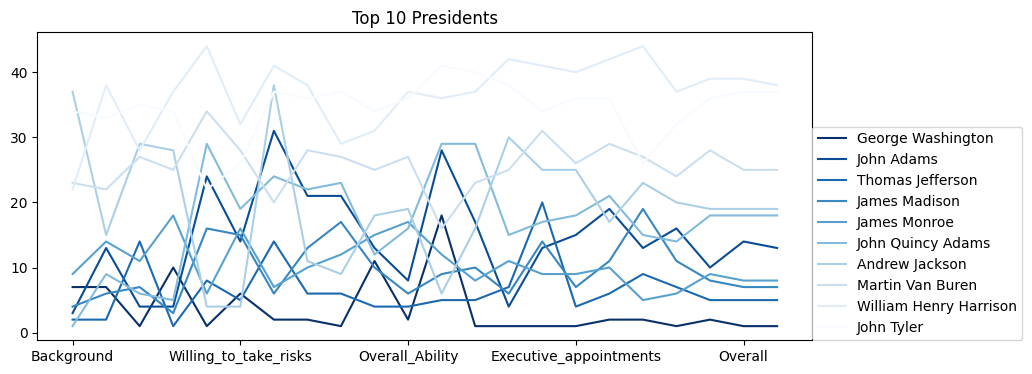

In [104]:
(pres
 .set_index('President')
 .select_dtypes('number') # set dtypes for memory
 .iloc[:10] # reduce number
 .T # flip data
 .plot(figsize=(10,4), title='Top 10 Presidents', cmap='Blues_r')
 .legend(loc=(1,0))
)

### Stacking and Unstacking
Stack and unstack are powerful methods to reshape your data.  Each has its specific use, but it is often linked with the groupby method.  Unstack in particular is paired with the groupby process.

Unstack is used to move an index or multi-index into the columns of the dataframe, creating hierarchical columns.  The stack method does the reverse, moving column index into the row index.  

In [105]:
(jb
 .groupby(['country_live','are_you_datascientist'])
 .size()
) # the result is correct, but hard to read

country_live  are_you_datascientist
Algeria       False                    14
              True                      5
              Other                     1
Argentina     False                    95
              True                     17
                                       ..
Venezuela     True                      4
              Other                     2
Viet Nam      False                    19
              True                     14
              Other                     3
Length: 228, dtype: int64

In [106]:
(jb
 .groupby(['country_live','are_you_datascientist'])
 .size()
 .unstack() # default behavior is to move the inned index to columns, and a Series turns into Dataframe
)

are_you_datascientist  False  True  Other
country_live                             
Algeria                   14     5      1
Argentina                 95    17      4
Armenia                   15     2      0
Australia                215    51     14
Austria                   95    33      3
...                      ...   ...    ...
United States           2066   601    101
Uruguay                   11     9      1
Uzbekistan                 3     1      0
Venezuela                 21     4      2
Viet Nam                  19    14      3

[76 rows x 3 columns]

In [107]:
(jb
 .groupby(['country_live','are_you_datascientist'])
 .size()
 .unstack(0) # Specify the level with the index starting from 0=outer and counting
)

country_live           Algeria  Argentina  Armenia  Australia  Austria  \
are_you_datascientist                                                    
False                       14         95       15        215       95   
True                         5         17        2         51       33   
Other                        1          4        0         14        3   

country_live           Bangladesh  Belarus  Belgium  Brazil  Bulgaria  ...  \
are_you_datascientist                                                  ...   
False                          25       46       98     329        33  ...   
True                           10        4       42     114         8  ...   
Other                           1        2        2      20         3  ...   

country_live           Tunisia  Turkey  Ukraine  United Arab Emirates  \
are_you_datascientist                                                   
False                        8      68      170                    14   
True                         1      32       25                     4   
Other                        0       4        9                     0   

country_live           United Kingdom  United States  Uruguay  Uzbekistan  \
are_you_datascientist                                                       
False                             538           2066       11           3   
True                              145            601        9           1   
Other                              37            101        1           0   

country_live           Venezuela  Viet Nam  
are_you_datascientist                       
False                         21        19  
True                           4        14  
Other                          2         3  

[3 rows x 76 columns]

In [108]:
(jb
 .groupby(['country_live','are_you_datascientist'])
 .size()
 .unstack('are_you_datascientist') # can explicitly tell it the name of the index
)

are_you_datascientist  False  True  Other
country_live                             
Algeria                   14     5      1
Argentina                 95    17      4
Armenia                   15     2      0
Australia                215    51     14
Austria                   95    33      3
...                      ...   ...    ...
United States           2066   601    101
Uruguay                   11     9      1
Uzbekistan                 3     1      0
Venezuela                 21     4      2
Viet Nam                  19    14      3

[76 rows x 3 columns]

### Stacking
This process allows the movement of hierarchical column levels into the index to restructure the data.

In [109]:
(jb
 .pivot_table(index='country_live', # pivot table creates hierarchy
              aggfunc={'age':['min','max'],
                       'company_size':['min','max']})
) 

age     company_size    
              max min          max min
country_live                          
Algeria        60  18         5000   1
Argentina      60  18         5000   1
Armenia        30  18         5000   1
Australia      60  18         5000   1
Austria        50  18         5000   1
...            ..  ..          ...  ..
United States  60  18         5000   1
Uruguay        40  21         5000   2
Uzbekistan     21  21         5000   1
Venezuela      50  18         5000   1
Viet Nam       60  18         5000   1

[76 rows x 4 columns]

In [110]:
(jb
 .pivot_table(index='country_live',
              aggfunc={'age':['min','max'],
                       'company_size':['min','max']})
 .stack(0) # moving outer column labels to index, must be done by location
) 

max min
country_live                       
Algeria      age             60  18
             company_size  5000   1
Argentina    age             60  18
             company_size  5000   1
Armenia      age             30  18
...                         ...  ..
Uzbekistan   company_size  5000   1
Venezuela    age             50  18
             company_size  5000   1
Viet Nam     age             60  18
             company_size  5000   1

[152 rows x 2 columns]

In [111]:
(jb
 .pivot_table(index='country_live',
              aggfunc={'age':['min','max'],
                       'company_size':['min','max']})
 .stack() # default behavior is inner most column level
) 

age company_size
country_live                     
Algeria      max  60         5000
             min  18            1
Argentina    max  60         5000
             min  18            1
Armenia      max  30         5000
...               ..          ...
Uzbekistan   min  21            1
Venezuela    max  50         5000
             min  18            1
Viet Nam     max  60         5000
             min  18            1

[152 rows x 2 columns]

In [112]:
(jb
 .pivot_table(index='country_live',
              aggfunc={'age':['min','max'],
                       'company_size':['min','max']})
 .stack() # default behavior is inner most column level
 .swaplevel() # switch index levels by default
) 

age company_size
    country_live                 
max Algeria       60         5000
min Algeria       18            1
max Argentina     60         5000
min Argentina     18            1
max Armenia       30         5000
...               ..          ...
min Uzbekistan    21            1
max Venezuela     50         5000
min Venezuela     18            1
max Viet Nam      60         5000
min Viet Nam      18            1

[152 rows x 2 columns]

### Flattening Hierarchical Indexes and Columns
These structures are often difficult to interpret and work with in practice.  In general, collapsing them can facilitate easier access to the resulting information for further analysis and visualization.

In [113]:
(jb
 .groupby(['country_live','age'])
 .mean()
) # hierarchical structure

company_size  nps_main_ide  team_size  years_of_coding  \
country_live age                                                           
Algeria      18            2.0     10.000000   2.000000         6.000000   
             21     725.428571      7.142857   2.857143         2.428571   
             30            1.6      8.400000   1.600000         3.800000   
             40         2014.6      8.600000   4.400000         4.400000   
             50           <NA>           NaN        NaN              NaN   
...                        ...           ...        ...              ...   
Viet Nam     21     335.481481      8.962963   4.703704         1.888889   
             30     179.666667      8.166667   4.333333         5.166667   
             40           51.0      9.000000   2.000000         6.000000   
             50           <NA>           NaN        NaN              NaN   
             60            1.0      8.000000   1.000000         1.000000   

                  python3_ver  
country_live age               
Algeria      18      3.650000  
             21      3.757143  
             30      3.700000  
             40      3.780000  
             50           NaN  
...                       ...  
Viet Nam     21      3.714815  
             30      3.783333  
             40      3.800000  
             50           NaN  
             60      3.900000  

[456 rows x 5 columns]

In [114]:
(jb
 .groupby(['country_live','age'])
 .mean()
 .reset_index() # this preserved the index as columns with repeated values
)

country_live  age  company_size  nps_main_ide  team_size  years_of_coding  \
0        Algeria   18           2.0     10.000000   2.000000         6.000000   
1        Algeria   21    725.428571      7.142857   2.857143         2.428571   
2        Algeria   30           1.6      8.400000   1.600000         3.800000   
3        Algeria   40        2014.6      8.600000   4.400000         4.400000   
4        Algeria   50          <NA>           NaN        NaN              NaN   
..           ...  ...           ...           ...        ...              ...   
451     Viet Nam   21    335.481481      8.962963   4.703704         1.888889   
452     Viet Nam   30    179.666667      8.166667   4.333333         5.166667   
453     Viet Nam   40          51.0      9.000000   2.000000         6.000000   
454     Viet Nam   50          <NA>           NaN        NaN              NaN   
455     Viet Nam   60           1.0      8.000000   1.000000         1.000000   

     python3_ver  
0       3.650000  
1       3.757143  
2       3.700000  
3       3.780000  
4            NaN  
..           ...  
451     3.714815  
452     3.783333  
453     3.800000  
454          NaN  
455     3.900000  

[456 rows x 7 columns]

### Hierarchical Columns
**Note:** Sadly, there is no convience method for flattening column structures.  This will require a hight level of effort if all of the column labels are to be pushed into a column similar to reset index.

In [117]:
def flatten_cols(df):
    cols=['_'.join(map(str,vals)) for vals in df.columns.to_flat_index()]
    df.columns = cols
    return df

In [126]:
(jb
 .groupby(['country_live','age'])
 .mean()
 .unstack() # creates column levels
#  .pipe(flatten_cols)
)

company_size                                         \
age                     18           21           30           40   
country_live                                                        
Algeria                2.0   725.428571          1.6       2014.6   
Argentina             51.0      438.125  1176.173913       1719.5   
Armenia               11.0  1015.461538   337.666667         <NA>   
Australia             4.25  1055.689655  1544.594595  1398.939394   
Austria               11.0     762.3125   919.555556   664.409091   
...                    ...          ...          ...          ...   
United States   691.390244  1640.646134   1649.23662  1760.827586   
Uruguay               <NA>         31.0   408.076923        751.0   
Uzbekistan            <NA>      1265.75         <NA>         <NA>   
Venezuela              2.0    21.153846          3.4    11.333333   
Viet Nam              51.0   335.481481   179.666667         51.0   

                                        nps_main_ide                      \
age                     50           60           18        21        30   
country_live                                                               
Algeria               <NA>       5000.0    10.000000  7.142857  8.400000   
Argentina       202.666667          2.0    10.000000  8.775000  8.717391   
Armenia               <NA>         <NA>    10.000000  9.000000  9.666667   
Australia      1480.193548        571.1     8.500000  8.637931  8.846847   
Austria         712.615385         <NA>    10.000000  8.718750  8.809524   
...                    ...          ...          ...       ...       ...   
United States  1922.028674  1799.212598     9.243902  8.955439  8.901408   
Uruguay               <NA>         <NA>          NaN  9.500000  9.076923   
Uzbekistan            <NA>         <NA>          NaN  9.750000       NaN   
Venezuela           2525.5         <NA>     8.000000  9.846154  7.400000   
Viet Nam              <NA>          1.0    10.000000  8.962963  8.166667   

                         ... years_of_coding                                   \
age                  40  ...              30         40         50         60   
country_live             ...                                                    
Algeria        8.600000  ...        3.800000   4.400000        NaN  11.000000   
Argentina      9.000000  ...        5.391304   8.909091  11.000000  11.000000   
Armenia             NaN  ...        5.000000        NaN        NaN        NaN   
Australia      8.621212  ...        6.297297   9.015152  10.096774   9.700000   
Austria        9.000000  ...        5.174603   7.772727  10.615385        NaN   
...                 ...  ...             ...        ...        ...        ...   
United States  8.937120  ...        6.053521   8.685598   9.917563  10.370079   
Uruguay        9.500000  ...        6.307692   7.000000        NaN        NaN   
Uzbekistan          NaN  ...             NaN        NaN        NaN        NaN   
Venezuela      8.833333  ...        5.200000  10.166667   8.500000        NaN   
Viet Nam       9.000000  ...        5.166667   6.000000        NaN   1.000000   

              python3_ver                                                    
age                    18        21        30        40        50        60  
country_live                                                                 
Algeria          3.650000  3.757143  3.700000  3.780000       NaN  3.900000  
Argentina        3.700000  3.760000  3.747826  3.731818  3.700000  3.800000  
Armenia          3.800000  3.784615  3.766667       NaN       NaN       NaN  
Australia        3.750000  3.739655  3.729730  3.724242  3.758065  3.760000  
Austria          3.800000  3.731250  3.726984  3.745455  3.692308       NaN  
...                   ...       ...       ...       ...       ...       ...  
United States    3.778049  3.737090  3.733615  3.744219  3.743369  3.746457  
Uruguay               NaN  3.750000  3.746154  3.800000       NaN  

In [124]:
(jb
 .groupby(['country_live','age'])
 .mean()
 .unstack() # creates column levels
#  .pipe(flatten_cols)
).columns.to_flat_index()

Index([   ('company_size', 18),    ('company_size', 21),
          ('company_size', 30),    ('company_size', 40),
          ('company_size', 50),    ('company_size', 60),
          ('nps_main_ide', 18),    ('nps_main_ide', 21),
          ('nps_main_ide', 30),    ('nps_main_ide', 40),
          ('nps_main_ide', 50),    ('nps_main_ide', 60),
             ('team_size', 18),       ('team_size', 21),
             ('team_size', 30),       ('team_size', 40),
             ('team_size', 50),       ('team_size', 60),
       ('years_of_coding', 18), ('years_of_coding', 21),
       ('years_of_coding', 30), ('years_of_coding', 40),
       ('years_of_coding', 50), ('years_of_coding', 60),
           ('python3_ver', 18),     ('python3_ver', 21),
           ('python3_ver', 30),     ('python3_ver', 40),
           ('python3_ver', 50),     ('python3_ver', 60)],
      dtype='object')

**FINAL MODIFICATION TO FLATTEN HIERARCHICAL COLUMN INDEX**

In [125]:
(jb
 .groupby(['country_live','age'])
 .mean()
 .unstack() # creates column levels
 .pipe(flatten_cols)
)

company_size_18  company_size_21  company_size_30  \
country_live                                                       
Algeria                    2.0       725.428571              1.6   
Argentina                 51.0          438.125      1176.173913   
Armenia                   11.0      1015.461538       337.666667   
Australia                 4.25      1055.689655      1544.594595   
Austria                   11.0         762.3125       919.555556   
...                        ...              ...              ...   
United States       691.390244      1640.646134       1649.23662   
Uruguay                   <NA>             31.0       408.076923   
Uzbekistan                <NA>          1265.75             <NA>   
Venezuela                  2.0        21.153846              3.4   
Viet Nam                  51.0       335.481481       179.666667   

               company_size_40  company_size_50  company_size_60  \
country_live                                                       
Algeria                 2014.6             <NA>           5000.0   
Argentina               1719.5       202.666667              2.0   
Armenia                   <NA>             <NA>             <NA>   
Australia          1398.939394      1480.193548            571.1   
Austria             664.409091       712.615385             <NA>   
...                        ...              ...              ...   
United States      1760.827586      1922.028674      1799.212598   
Uruguay                  751.0             <NA>             <NA>   
Uzbekistan                <NA>             <NA>             <NA>   
Venezuela            11.333333           2525.5             <NA>   
Viet Nam                  51.0             <NA>              1.0   

               nps_main_ide_18  nps_main_ide_21  nps_main_ide_30  \
country_live                                                       
Algeria              10.000000         7.142857         8.400000   
Argentina            10.000000         8.775000         8.717391   
Armenia              10.000000         9.000000         9.666667   
Australia             8.500000         8.637931         8.846847   
Austria              10.000000         8.718750         8.809524   
...                        ...              ...              ...   
United States         9.243902         8.955439         8.901408   
Uruguay                    NaN         9.500000         9.076923   
Uzbekistan                 NaN         9.750000              NaN   
Venezuela             8.000000         9.846154         7.400000   
Viet Nam             10.000000         8.962963         8.166667   

               nps_main_ide_40  ...  years_of_coding_30  years_of_coding_40  \
country_live                    ...                                           
Algeria               8.600000  ...            3.800000            4.400000   
Argentina             9.000000  ...            5.391304            8.909091   
Armenia                    NaN  ...            5.000000                 NaN   
Australia             8.621212  ...            6.297297            9.015152   
Austria               9.000000  ...            5.174603            7.772727   
...                        ...  ...                 ...                 ...   
United States         8.937120  ...            6.053521            8.685598   
Uruguay               9.500000  ...            6.307692            7.000000   
Uzbekistan                 NaN  ...                 NaN                 NaN   
Venezuela             8.833333  ...            5.200000           10.166667   
Viet Nam              9.000000  ...            5.166667            6.000000   

               years_of_coding_50  years_of_coding_60  python3_ver_18  \
country_live                                                            
Algeria                       NaN           11.000000        3.650000   
Argentina               11.000000           11.000000        3.700000   
Armenia                       NaN       


>Another Example:

In [129]:
(cars
 [['make','year','cylinders','drive']]
 .groupby('make')
 .agg(['min','max'])
 .pipe(flatten_cols)
)

year_min  year_max  cylinders_min  cylinders_max
make                                                                         
AM General                       1984      1985            4.0            6.0
ASC Incorporated                 1987      1987            6.0            6.0
Acura                            1986      2023            4.0            6.0
Alfa Romeo                       1984      2023            4.0            8.0
American Motors Corporation      1984      1987            4.0            6.0
...                               ...       ...            ...            ...
Volkswagen                       1984      2023            4.0           12.0
Volvo                            1984      2023            4.0            8.0
Wallace Environmental            1991      1992            4.0           12.0
Yugo                             1986      1990            4.0            4.0
smart                            2008      2019            3.0            3.0

[141 rows x 4 columns]